In [1]:
import json
import os
import matplotlib.pyplot as plt
import numpy as np
from typing import List, Dict, Any, Tuple, Optional

# ... (Keep _aggregate_batch_metric_per_epoch and _align_epoch_metric as they are) ...

# --- Plotting Function (Modified _plot_metric) ---
def _plot_metric(
        fig_num: int, title: str, ylabel: str,
        epoch_ticks: np.ndarray,
        num_epochs: int,
        output_dir: str,
        flag_epochs_map: Dict[int, List[str]],
        train_metric: Optional[List[float]] = None,
        val_metric: Optional[List[float]] = None,
        other_metrics: Optional[Dict[str, List[float]]] = None,
        filename: str = "plot.png",
        log_scale_y: bool = False
):
    plt.figure(fig_num, figsize=(14, 8))
    plt.clf()

    legend_handles_main = []

    if train_metric and len(train_metric) == num_epochs:
        p, = plt.plot(epoch_ticks, train_metric, label='Training', marker='.', markersize=5, linewidth=1.5)
        legend_handles_main.append(p)
    if val_metric and len(val_metric) == num_epochs:
        p, = plt.plot(epoch_ticks, val_metric, label='Validation', marker='.', markersize=5, linewidth=1.5)
        legend_handles_main.append(p)

    if other_metrics:
        for name, metric_data in other_metrics.items():
            if len(metric_data) == num_epochs:
                valid_indices = [i for i, val in enumerate(metric_data) if not np.isnan(val)]
                if valid_indices:
                    current_epoch_ticks_to_plot = epoch_ticks[valid_indices]
                    current_metric_data_to_plot = np.array(metric_data)[valid_indices]
                    p, = plt.plot(current_epoch_ticks_to_plot, current_metric_data_to_plot, label=name,
                                  marker='.' if len(valid_indices) < 50 else None, linestyle='--', linewidth=1.5)
                    legend_handles_main.append(p)

    flag_legend_handles_map = {}
    flag_color_map = {
        "OVERFITTING": "red",
        "VAL_LOSS_PLATEAU": "orange",
        "LOW_GRADIENT_NORM": "purple",         # Original flag from training
        "LOW_WEIGHT_UPDATE_NORM": "brown",     # Original flag from training
        "ADAM_STALLED": "cyan",
        "SGD_STALLED": "teal",
        "HIGH_SHARPNESS": "magenta",
        # New colors for plot-time threshold flags
        "PLOT_LOW_GRAD_NORM": "darkorchid",   # Plot-time evaluation
        "PLOT_LOW_WU_NORM": "sienna",         # Plot-time evaluation
        "PLOT_VAL_LOSS_PLATEAU": "gold",      # Plot-time evaluation
        "PLOT_OVERFITTING": "crimson",        # Plot-time evaluation
        "DEFAULT_FLAG_COLOR": "gray"
    }

    if flag_epochs_map:
        for epoch_flagged, flag_types_at_epoch in flag_epochs_map.items():
            if epoch_flagged in epoch_ticks: # Ensure the epoch is one that's being plotted
                for flag_type in flag_types_at_epoch:
                    color = flag_color_map.get(flag_type, flag_color_map["DEFAULT_FLAG_COLOR"])
                    if flag_type not in flag_legend_handles_map:
                        dummy_line = plt.Line2D([0], [0], color=color, linestyle=':', linewidth=2, label=f"{flag_type} Event")
                        flag_legend_handles_map[flag_type] = dummy_line
                    plt.axvline(x=epoch_flagged, color=color, linestyle=':', linewidth=1.5, alpha=0.7)

    combined_legend_handles = legend_handles_main + sorted(list(flag_legend_handles_map.values()), key=lambda x: x.get_label())

    plt.title(title, fontsize=16)
    plt.xlabel("Epoch", fontsize=12)
    plt.ylabel(ylabel, fontsize=12)
    if log_scale_y:
        plt.yscale('log')
    plt.grid(True, which="both", ls="-", alpha=0.5)
    if combined_legend_handles:
        plt.legend(handles=combined_legend_handles, fontsize=10)
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, filename))
    plt.close(fig_num)
    print(f"Saved plot: {filename}")


# --- Main plotting function (plot_metrics_with_flags modified) ---
def plot_metrics_with_flags(
        json_file_path: str,
        output_dir: str = "experiment_plots",
        # New parameters for plot-time threshold checks
        plot_threshold_low_grad_norm: Optional[float] = None,
        plot_threshold_low_weight_update: Optional[float] = None,
        plot_threshold_val_loss_plateau_delta: Optional[float] = None,
        plot_threshold_val_loss_plateau_window: int = 5, # Default window for plateau check
        plot_threshold_overfitting_window: int = 5, # Default window for overfitting check
        plot_threshold_overfitting_min_epochs: int = 3 # Min epochs for val loss up / train loss down
):
    if not os.path.exists(json_file_path):
        print(f"Error: JSON file not found at {json_file_path}")
        return

    os.makedirs(output_dir, exist_ok=True)
    print(f"Loading metrics from: {json_file_path}")
    print(f"Saving plots to: {output_dir}")

    with open(json_file_path, 'r') as f:
        raw_data = json.load(f)

    # ... (Standardize data structure access - keep this part as is) ...
    epochs_data_dict = {}
    flags_history_list = []

    if isinstance(raw_data, dict): # Likely all_metrics.json
        print(f"Info: Input file {json_file_path} is a dictionary. Attempting to parse comprehensive metrics.")
        epochs_data_dict['epochs_completed'] = raw_data.get('epochs', [])
        epochs_data_dict['train_loss_history'] = raw_data.get('train_loss_history', [])
        epochs_data_dict['train_acc_history'] = raw_data.get('train_acc_history', [])
        epochs_data_dict['val_loss_history'] = raw_data.get('val_loss_history', [])
        epochs_data_dict['val_acc_history'] = raw_data.get('val_acc_history', [])
        epochs_data_dict['lr_history'] = raw_data.get('lr_history', [])
        flags_history_list = raw_data.get('optimization_flags_history', [])
    elif isinstance(raw_data, list): # Likely epoch_metric.json
        # ... (keep this section for handling simpler list-based JSON) ...
        print(f"Info: Input file {json_file_path} is a list (likely epoch_metric.json).")
        epochs_data_dict['epochs_completed'] = [r.get("epoch") for r in raw_data if "epoch" in r]
        epochs_data_dict['train_loss_history'] = [r.get("train_loss") for r in raw_data if "train_loss" in r]
        epochs_data_dict['train_acc_history'] = [r.get("train_acc") for r in raw_data if "train_acc" in r]
        epochs_data_dict['val_loss_history'] = [r.get("val_loss") for r in raw_data if "val_loss" in r]
        epochs_data_dict['val_acc_history'] = [r.get("val_acc") for r in raw_data if "val_acc" in r]
        epochs_data_dict['lr_history'] = [r.get("learning_rate") for r in raw_data if "learning_rate" in r]
        for key, val_list in epochs_data_dict.items():
            epochs_data_dict[key] = [v for v in val_list if v is not None]
    else:
        print(f"Error: Unknown JSON structure in {json_file_path}")
        return

    epochs = epochs_data_dict.get('epochs_completed', [])
    if not epochs:
        print("No epoch data found ('epochs' key in JSON is missing or empty). Cannot generate plots.")
        return

    num_epochs = len(epochs)
    epoch_ticks = np.array(epochs)

    train_loss = epochs_data_dict.get('train_loss_history', [])
    val_loss = epochs_data_dict.get('val_loss_history', [])
    train_acc = [a * 100 if isinstance(a, (int, float)) else float('nan') for a in epochs_data_dict.get('train_acc_history', [])]
    val_acc = [a * 100 if isinstance(a, (int, float)) else float('nan') for a in epochs_data_dict.get('val_acc_history', [])]
    lr_history = epochs_data_dict.get('lr_history', [])

    # Extract original flags from JSON
    flag_epochs_map: Dict[int, List[str]] = {}
    if flags_history_list:
        for flag_event in flags_history_list:
            epoch = flag_event.get('epoch')
            flag_type = flag_event.get('flag_type', 'UNKNOWN_FLAG')
            if epoch is not None:
                if epoch not in flag_epochs_map:
                    flag_epochs_map[epoch] = []
                if flag_type not in flag_epochs_map[epoch]: # Avoid duplicates of same original flag
                    flag_epochs_map[epoch].append(flag_type)
    elif isinstance(raw_data, dict):
        print("No 'optimization_flags_history' found in JSON. Original flags will not be highlighted.")

    # --- Calculate metrics needed for plot-time threshold evaluation ---
    epoch_avg_grad_norms = []
    batch_grad_norms_history = raw_data.get('gradient_norms', []) if isinstance(raw_data, dict) else []
    if batch_grad_norms_history:
        epoch_avg_grad_norms = _aggregate_batch_metric_per_epoch(batch_grad_norms_history, epochs, 'total_norm')

    aligned_wu_norms = []
    weight_update_history = raw_data.get('weight_update_norm_history', []) if isinstance(raw_data, dict) else []
    if weight_update_history:
        aligned_wu_norms = _align_epoch_metric(weight_update_history, epochs, 'norm')

    # --- Evaluate plot-time thresholds and add to flag_epochs_map ---

    # Plot-time: LOW_GRADIENT_NORM
    if plot_threshold_low_grad_norm is not None and epoch_avg_grad_norms and len(epoch_avg_grad_norms) == num_epochs:
        for i, epoch_val in enumerate(epochs):
            if not np.isnan(epoch_avg_grad_norms[i]) and epoch_avg_grad_norms[i] < plot_threshold_low_grad_norm:
                flag_type = "PLOT_LOW_GRAD_NORM"
                if epoch_val not in flag_epochs_map: flag_epochs_map[epoch_val] = []
                if flag_type not in flag_epochs_map[epoch_val]: flag_epochs_map[epoch_val].append(flag_type)

    # Plot-time: LOW_WEIGHT_UPDATE_NORM
    if plot_threshold_low_weight_update is not None and aligned_wu_norms and len(aligned_wu_norms) == num_epochs:
        for i, epoch_val in enumerate(epochs):
            if not np.isnan(aligned_wu_norms[i]) and aligned_wu_norms[i] < plot_threshold_low_weight_update:
                flag_type = "PLOT_LOW_WU_NORM"
                if epoch_val not in flag_epochs_map: flag_epochs_map[epoch_val] = []
                if flag_type not in flag_epochs_map[epoch_val]: flag_epochs_map[epoch_val].append(flag_type)

    # Plot-time: VAL_LOSS_PLATEAU
    if plot_threshold_val_loss_plateau_delta is not None and val_loss and len(val_loss) == num_epochs:
        if num_epochs >= plot_threshold_val_loss_plateau_window:
            for i in range(plot_threshold_val_loss_plateau_window - 1, num_epochs):
                window_val_losses = val_loss[i - plot_threshold_val_loss_plateau_window + 1 : i + 1]
                if all(not np.isnan(x) for x in window_val_losses): # Ensure no NaNs in window
                    net_improvement = window_val_losses[0] - window_val_losses[-1]
                    if net_improvement < plot_threshold_val_loss_plateau_delta:
                        epoch_val = epochs[i]
                        flag_type = "PLOT_VAL_LOSS_PLATEAU"
                        if epoch_val not in flag_epochs_map: flag_epochs_map[epoch_val] = []
                        if flag_type not in flag_epochs_map[epoch_val]: flag_epochs_map[epoch_val].append(flag_type)

    # Plot-time: OVERFITTING
    if train_loss and val_loss and len(train_loss) == num_epochs and len(val_loss) == num_epochs:
        if num_epochs >= plot_threshold_overfitting_window:
            for i in range(plot_threshold_overfitting_window - 1, num_epochs):
                window_train_losses = train_loss[i - plot_threshold_overfitting_window + 1 : i + 1]
                window_val_losses = val_loss[i - plot_threshold_overfitting_window + 1 : i + 1]

                if all(not np.isnan(x) for x in window_train_losses) and \
                        all(not np.isnan(x) for x in window_val_losses):
                    val_loss_increasing_count = sum(1 for k in range(1, plot_threshold_overfitting_window) if window_val_losses[k] > window_val_losses[k-1])
                    train_loss_decreasing_count = sum(1 for k in range(1, plot_threshold_overfitting_window) if window_train_losses[k] < window_train_losses[k-1])

                    if val_loss_increasing_count >= plot_threshold_overfitting_min_epochs and \
                            train_loss_decreasing_count >= plot_threshold_overfitting_min_epochs:
                        epoch_val = epochs[i]
                        flag_type = "PLOT_OVERFITTING"
                        if epoch_val not in flag_epochs_map: flag_epochs_map[epoch_val] = []
                        if flag_type not in flag_epochs_map[epoch_val]: flag_epochs_map[epoch_val].append(flag_type)


    # --- Generate Plots (Calls to _plot_metric are the same, but flag_epochs_map is now augmented) ---
    # ... (Length mismatch warnings - keep as is) ...
    # ... (Calls to _plot_metric for loss, accuracy, LR, etc. - keep as is, ensuring
    #      epoch_ticks, num_epochs, output_dir, flag_epochs_map are passed correctly)

    _plot_metric(1, "Training & Validation Loss vs. Epoch", "Loss",
                 epoch_ticks=epoch_ticks, num_epochs=num_epochs, output_dir=output_dir, flag_epochs_map=flag_epochs_map,
                 train_metric=train_loss if train_loss and len(train_loss) == num_epochs else None,
                 val_metric=val_loss if val_loss and len(val_loss) == num_epochs else None,
                 filename="loss_vs_epoch.png", log_scale_y=True)

    _plot_metric(2, "Training & Validation Accuracy vs. Epoch", "Accuracy (%)",
                 epoch_ticks=epoch_ticks, num_epochs=num_epochs, output_dir=output_dir, flag_epochs_map=flag_epochs_map,
                 train_metric=train_acc if train_acc and len(train_acc) == num_epochs else None,
                 val_metric=val_acc if val_acc and len(val_acc) == num_epochs else None,
                 filename="accuracy_vs_epoch.png")

    _plot_metric(3, "Learning Rate vs. Epoch", "Learning Rate",
                 epoch_ticks=epoch_ticks, num_epochs=num_epochs, output_dir=output_dir, flag_epochs_map=flag_epochs_map,
                 other_metrics={"Learning Rate": lr_history if lr_history and len(lr_history) == num_epochs else [float('nan')] * num_epochs},
                 filename="lr_vs_epoch.png", log_scale_y=True)

    if epoch_avg_grad_norms and any(not np.isnan(x) for x in epoch_avg_grad_norms):
        _plot_metric(4, "Average Gradient Norm vs. Epoch", "Avg L2 Norm of Gradients",
                     epoch_ticks=epoch_ticks, num_epochs=num_epochs, output_dir=output_dir, flag_epochs_map=flag_epochs_map,
                     other_metrics={"Avg Grad Norm": epoch_avg_grad_norms},
                     filename="grad_norm_vs_epoch.png", log_scale_y=True)

    if aligned_wu_norms and any(not np.isnan(x) for x in aligned_wu_norms):
        _plot_metric(5, "Weight Update Norm vs. Epoch", "L2 Norm of Weight Updates",
                     epoch_ticks=epoch_ticks, num_epochs=num_epochs, output_dir=output_dir, flag_epochs_map=flag_epochs_map,
                     other_metrics={"Weight Update Norm": aligned_wu_norms},
                     filename="weight_update_norm_vs_epoch.png", log_scale_y=True)

    # ... (Keep plotting for optimizer state, noise, etc. as is, passing the new flag_epochs_map) ...
    optimizer_state_history = raw_data.get('optimizer_state_history', []) if isinstance(raw_data, dict) else []
    if optimizer_state_history:
        aligned_m_norms = _align_epoch_metric(optimizer_state_history, epochs, 'avg_m_norm')
        aligned_eff_lrs = _align_epoch_metric(optimizer_state_history, epochs, 'avg_eff_lr')
        aligned_momentum_norms = _align_epoch_metric(optimizer_state_history, epochs, 'avg_momentum_norm')

        adam_metrics_to_plot = {}
        if any(not np.isnan(x) for x in aligned_m_norms): adam_metrics_to_plot['Avg Adam m_norm'] = aligned_m_norms
        if any(not np.isnan(x) for x in aligned_eff_lrs): adam_metrics_to_plot['Avg Adam eff_LR'] = aligned_eff_lrs

        sgd_metrics_to_plot = {}
        if any(not np.isnan(x) for x in aligned_momentum_norms): sgd_metrics_to_plot['Avg SGD Momentum Norm'] = aligned_momentum_norms

        if adam_metrics_to_plot:
            _plot_metric(6, "Adam Optimizer State vs. Epoch", "Metric Value",
                         epoch_ticks=epoch_ticks, num_epochs=num_epochs, output_dir=output_dir, flag_epochs_map=flag_epochs_map,
                         other_metrics=adam_metrics_to_plot, filename="adam_state_vs_epoch.png", log_scale_y=True)
        if sgd_metrics_to_plot:
            _plot_metric(7, "SGD Optimizer State vs. Epoch", "Avg Momentum Norm",
                         epoch_ticks=epoch_ticks, num_epochs=num_epochs, output_dir=output_dir, flag_epochs_map=flag_epochs_map,
                         other_metrics=sgd_metrics_to_plot, filename="sgd_state_vs_epoch.png", log_scale_y=True)


    noise_history = raw_data.get('noise_metrics_history', []) if isinstance(raw_data, dict) else []
    if noise_history:
        aligned_noise_mags = _align_epoch_metric(noise_history, epochs, 'magnitude')
        if any(not np.isnan(x) for x in aligned_noise_mags):
            _plot_metric(8, "Noise Magnitude vs. Epoch", "Magnitude",
                         epoch_ticks=epoch_ticks, num_epochs=num_epochs, output_dir=output_dir, flag_epochs_map=flag_epochs_map,
                         other_metrics={"Noise Magnitude": aligned_noise_mags},
                         filename="noise_magnitude_vs_epoch.png")


    print(f"Finished generating plots in {output_dir}.")


# --- Example usage ---
# json_file = r"path_to_your/all_metrics.json"
# output_plot_dir = "my_experiment_plots_with_thresholds"

# plot_metrics_with_flags(
#     json_file_path=json_file,
#     output_dir=output_plot_dir,
#     plot_threshold_low_grad_norm=1e-5,       # Example: Highlight if avg grad norm < 1e-5
#     plot_threshold_low_weight_update=1e-4, # Example: Highlight if weight update norm < 1e-4
#     plot_threshold_val_loss_plateau_delta=0.0001, # Example plateau delta
#     plot_threshold_val_loss_plateau_window=5,
#     plot_threshold_overfitting_window=5,
#     plot_threshold_overfitting_min_epochs=2
# )

In [2]:
# Replace with the actual path to your metrics file
# Ensure the path uses forward slashes or is a raw string if using backslashes
json_file = r"C:\Users\Home\Documents\EPFL\OptML\OptML\PyTorch_CIFAR10\checkpoints\metrics\resnet18_none_20250515_094307/all_metrics.json"
output_plot_dir = "my_experiment_plots"

plot_metrics_with_flags(json_file_path=json_file,
     output_dir=output_plot_dir,
    plot_threshold_low_grad_norm=1,       # Example: Highlight if avg grad norm < 1e-5
     plot_threshold_low_weight_update=10, # Example: Highlight if weight update norm < 1e-4
     plot_threshold_val_loss_plateau_delta=0.0001, # Example plateau delta
    plot_threshold_val_loss_plateau_window=10,
     plot_threshold_overfitting_window=10,
     plot_threshold_overfitting_min_epochs=5
)

Error: JSON file not found at C:\Users\Home\Documents\EPFL\OptML\OptML\PyTorch_CIFAR10\checkpoints\metrics\resnet18_none_20250515_094307/all_metrics.json


In [38]:
json_file = r"C:\Users\Home\Documents\EPFL\OptML\OptML\PyTorch_CIFAR10\checkpoints\metrics\resnet18_none_20250602_143348\all_metrics.json"
output_plot_dir = "my_experiment_plots_last_try"

plot_metrics_with_flags(json_file_path=json_file,
                        output_dir=output_plot_dir,
                        plot_threshold_low_grad_norm=1e-3,       # Example: Highlight if avg grad norm < 1e-5
                        plot_threshold_low_weight_update=1e-2, # Example: Highlight if weight update norm < 1e-4
                        plot_threshold_val_loss_plateau_delta=0.0001, # Example plateau delta
                        plot_threshold_val_loss_plateau_window=10,
                        plot_threshold_overfitting_window=10,
                        plot_threshold_overfitting_min_epochs=5
                        
                        
                        )

Loading metrics from: C:\Users\Home\Documents\EPFL\OptML\OptML\PyTorch_CIFAR10\checkpoints\metrics\resnet18_none_20250602_143348\all_metrics.json
Saving plots to: my_experiment_plots_last_try
Info: Input file C:\Users\Home\Documents\EPFL\OptML\OptML\PyTorch_CIFAR10\checkpoints\metrics\resnet18_none_20250602_143348\all_metrics.json is a dictionary. Attempting to parse comprehensive metrics.
No 'optimization_flags_history' found in JSON. Original flags will not be highlighted.
Saved plot: loss_vs_epoch.png
Saved plot: accuracy_vs_epoch.png
Saved plot: lr_vs_epoch.png
Saved plot: grad_norm_vs_epoch.png
Finished generating plots in my_experiment_plots_last_try.


In [1]:
import json
import os
import matplotlib.pyplot as plt
import numpy as np
from typing import List, Dict, Any, Tuple, Optional

# --- Helper functions (These can remain as functions) ---

def _aggregate_batch_metric_per_epoch(batch_metrics_history: List[Dict[str, Any]], epochs: List[int], metric_key: str) -> List[float]:
    """Aggregates a batch-level metric to an average per epoch."""
    epoch_to_sum = {epoch_num: 0.0 for epoch_num in epochs}
    epoch_to_count = {epoch_num: 0 for epoch_num in epochs}

    for entry in batch_metrics_history:
        epoch_num = entry.get('epoch')
        metric_val = entry.get(metric_key)
        if epoch_num is not None and metric_val is not None:
            epoch_to_sum[epoch_num] += metric_val
            epoch_to_count[epoch_num] += 1

    aggregated_metrics = []
    for epoch_num in epochs:
        if epoch_to_count[epoch_num] > 0:
            aggregated_metrics.append(epoch_to_sum[epoch_num] / epoch_to_count[epoch_num])
        else:
            aggregated_metrics.append(float('nan')) # No data for this epoch
    return aggregated_metrics

def _align_epoch_metric(history: List[Dict[str, Any]], target_epochs: List[int], metric_key: str) -> List[float]:
    """Aligns a list of metric dictionaries to a target list of epochs."""
    aligned_values = [float('nan')] * len(target_epochs)
    epoch_to_index = {epoch: i for i, epoch in enumerate(target_epochs)}

    for entry in history:
        epoch = entry.get('epoch')
        value = entry.get(metric_key)
        if epoch is not None and value is not None and epoch in epoch_to_index:
            aligned_values[epoch_to_index[epoch]] = value
    return aligned_values

def _plot_metric(
        fig_num: int, title: str, ylabel: str,
        epoch_ticks: np.ndarray,
        num_epochs: int,
        output_dir: str,
        flag_epochs_map: Dict[int, List[str]],
        train_metric: Optional[List[float]] = None,
        val_metric: Optional[List[float]] = None,
        other_metrics: Optional[Dict[str, List[float]]] = None,
        filename: str = "plot.png",
        log_scale_y: bool = False
):
    plt.figure(fig_num, figsize=(14, 8))
    plt.clf() # Clear the current figure to prevent plots from overlapping on successive runs

    legend_handles_main = []

    if train_metric is not None and len(train_metric) == num_epochs: # Check for None explicitly
        p, = plt.plot(epoch_ticks, train_metric, label='Training', marker='.', markersize=5, linewidth=1.5)
        legend_handles_main.append(p)
    if val_metric is not None and len(val_metric) == num_epochs: # Check for None explicitly
        p, = plt.plot(epoch_ticks, val_metric, label='Validation', marker='.', markersize=5, linewidth=1.5)
        legend_handles_main.append(p)

    if other_metrics:
        for name, metric_data in other_metrics.items():
            if metric_data is not None and len(metric_data) == num_epochs: # Check for None explicitly
                valid_indices = [i for i, val in enumerate(metric_data) if not np.isnan(val)]
                if valid_indices:
                    current_epoch_ticks_to_plot = epoch_ticks[valid_indices]
                    current_metric_data_to_plot = np.array(metric_data)[valid_indices]
                    p, = plt.plot(current_epoch_ticks_to_plot, current_metric_data_to_plot, label=name,
                                  marker='.' if len(valid_indices) < 50 else None, linestyle='--', linewidth=1.5)
                    legend_handles_main.append(p)

    flag_legend_handles_map = {}
    flag_color_map = {
        "OVERFITTING": "red",
        "VAL_LOSS_PLATEAU": "orange",
        "LOW_GRADIENT_NORM": "purple",
        "LOW_WEIGHT_UPDATE_NORM": "brown",
        "ADAM_STALLED": "cyan",
        "SGD_STALLED": "teal",
        "HIGH_SHARPNESS": "magenta",
        "DEFAULT_FLAG_COLOR": "gray"
    }

    if flag_epochs_map:
        for epoch_flagged, flag_types_at_epoch in flag_epochs_map.items():
            if epoch_flagged in epoch_ticks:
                for flag_type in flag_types_at_epoch:
                    color = flag_color_map.get(flag_type, flag_color_map["DEFAULT_FLAG_COLOR"])
                    if flag_type not in flag_legend_handles_map:
                        dummy_line = plt.Line2D([0], [0], color=color, linestyle=':', linewidth=2, label=f"{flag_type} Event")
                        flag_legend_handles_map[flag_type] = dummy_line
                    plt.axvline(x=epoch_flagged, color=color, linestyle=':', linewidth=1.5, alpha=0.7)

    combined_legend_handles = legend_handles_main + sorted(list(flag_legend_handles_map.values()), key=lambda x: x.get_label())

    plt.title(title, fontsize=16)
    plt.xlabel("Epoch", fontsize=12)
    plt.ylabel(ylabel, fontsize=12)
    if log_scale_y:
        plt.yscale('log')
    plt.grid(True, which="both", ls="-", alpha=0.5)
    if combined_legend_handles:
        plt.legend(handles=combined_legend_handles, fontsize=10)
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, filename))
    plt.show() # Display plot in Jupyter notebook
    plt.close(fig_num) # Close figure to free memory after showing
    print(f"Saved plot: {filename}")


Loading metrics from: C:\Users\Home\Documents\EPFL\OptML\OptML\PyTorch_CIFAR10\checkpoints\metrics\baby_cnn_none_20250609_190202\all_metrics.json
Saving plots to: my_experiment_plots
Info: Input file C:\Users\Home\Documents\EPFL\OptML\OptML\PyTorch_CIFAR10\checkpoints\metrics\baby_cnn_none_20250609_190202\all_metrics.json is a dictionary. Parsing comprehensive metrics.
No 'optimization_flags_history' found in JSON. Triggered flags from training will not be highlighted.


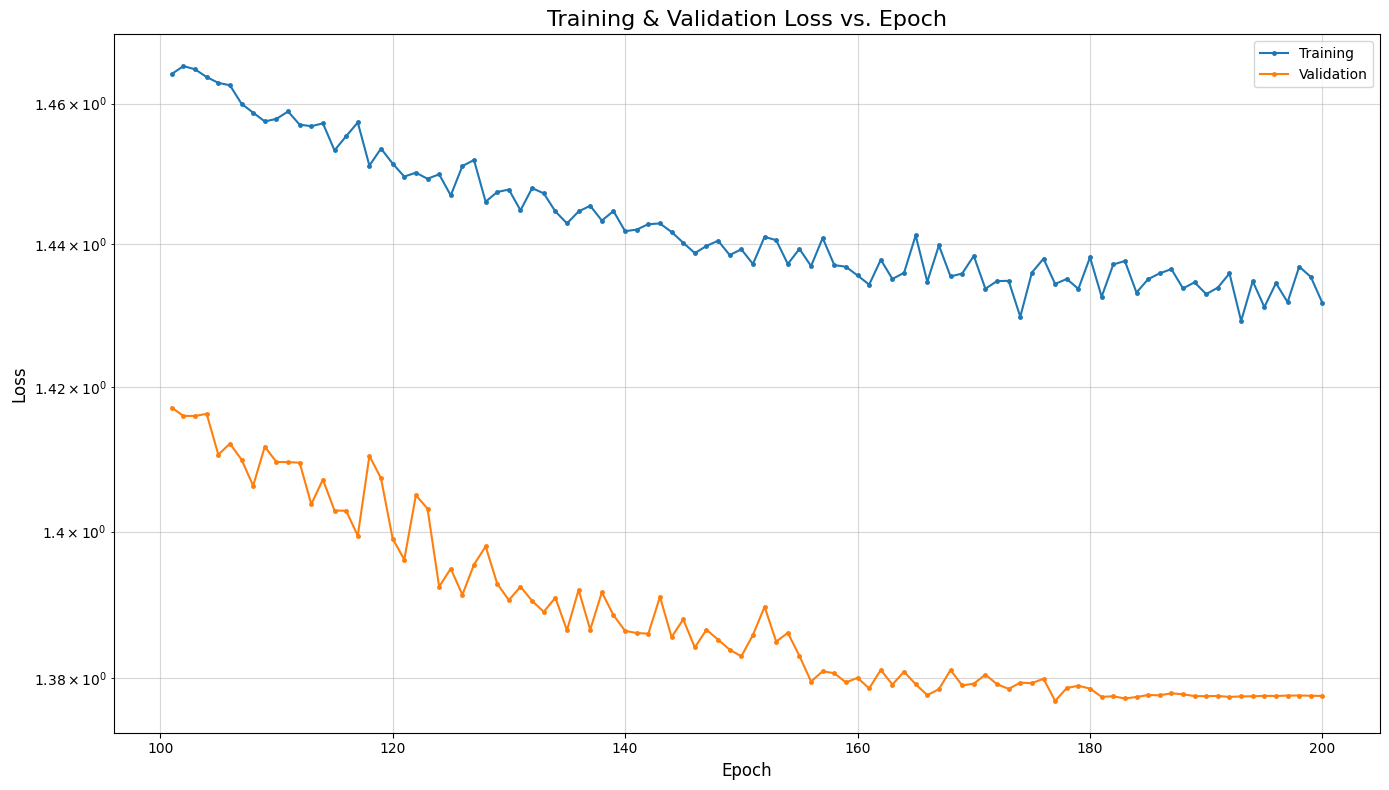

Saved plot: loss_vs_epoch.png


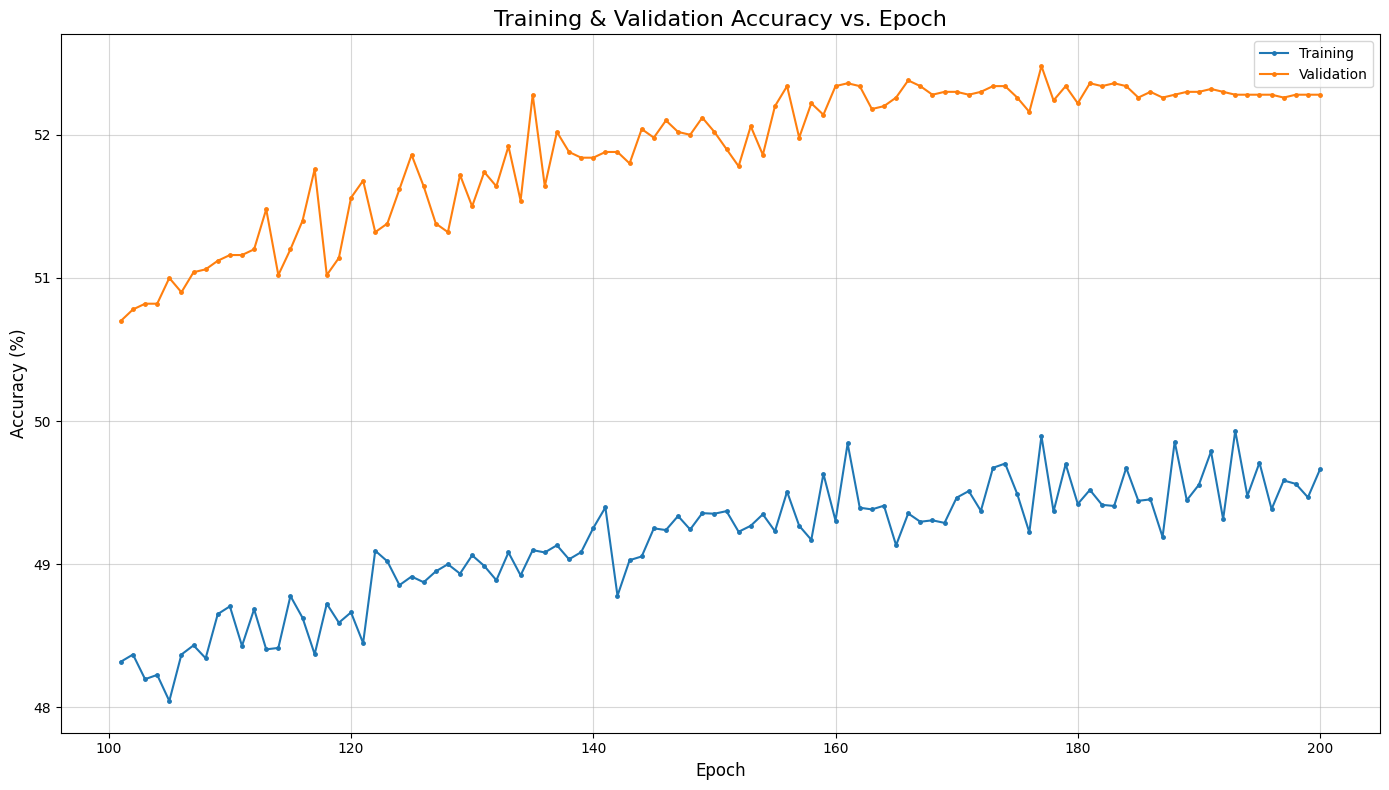

Saved plot: accuracy_vs_epoch.png


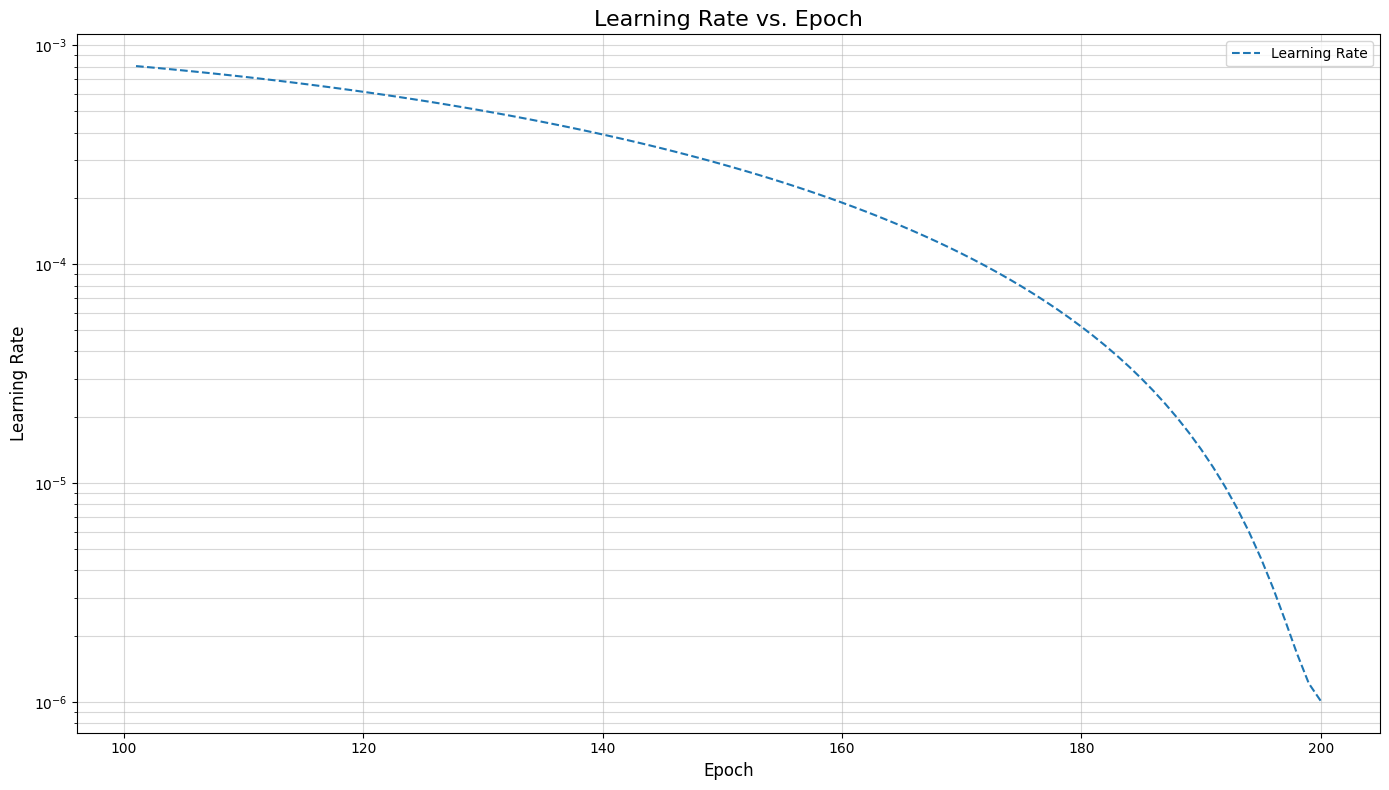

Saved plot: lr_vs_epoch.png


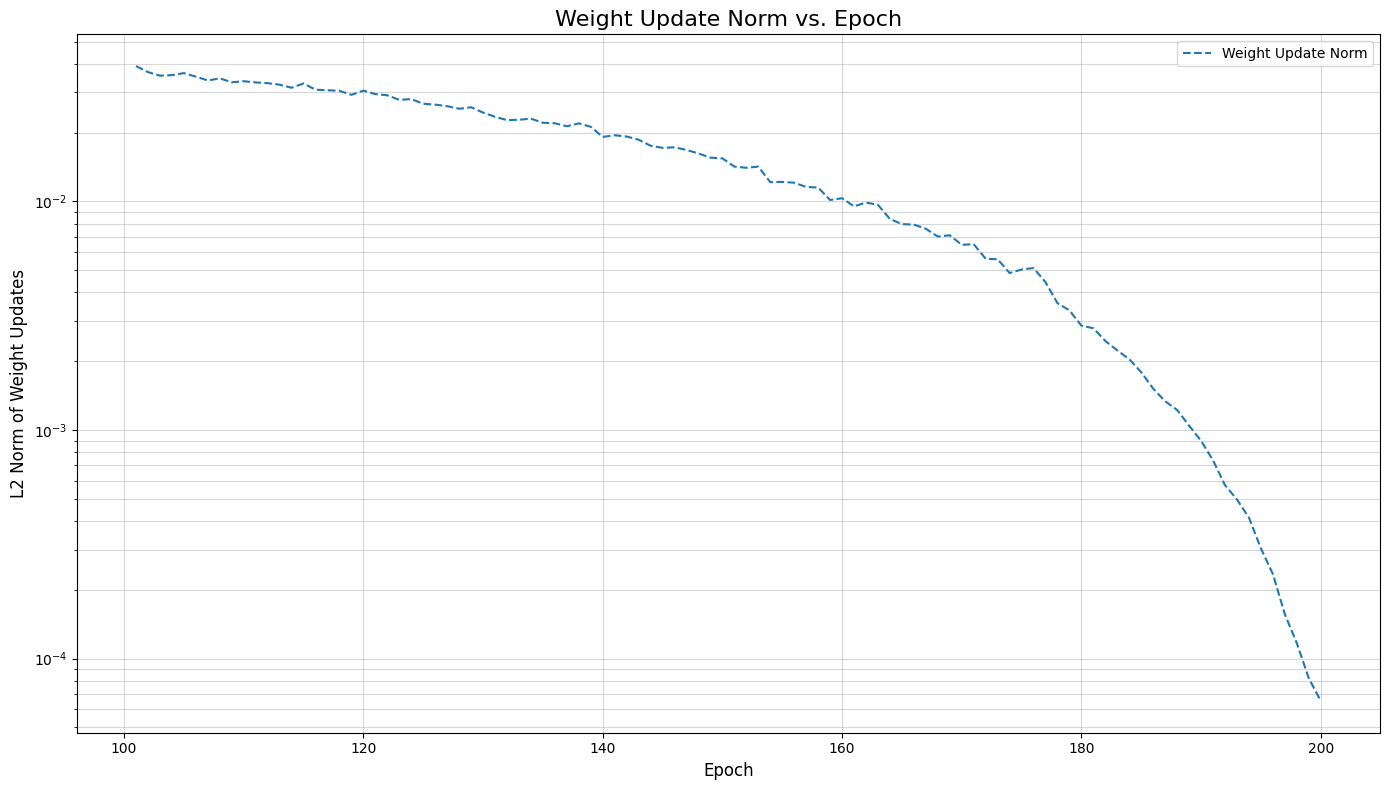

Saved plot: weight_update_norm_vs_epoch.png


C:\Users\Home\AppData\Local\Temp\ipykernel_22372\1715112738.py:104: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.yscale('log')


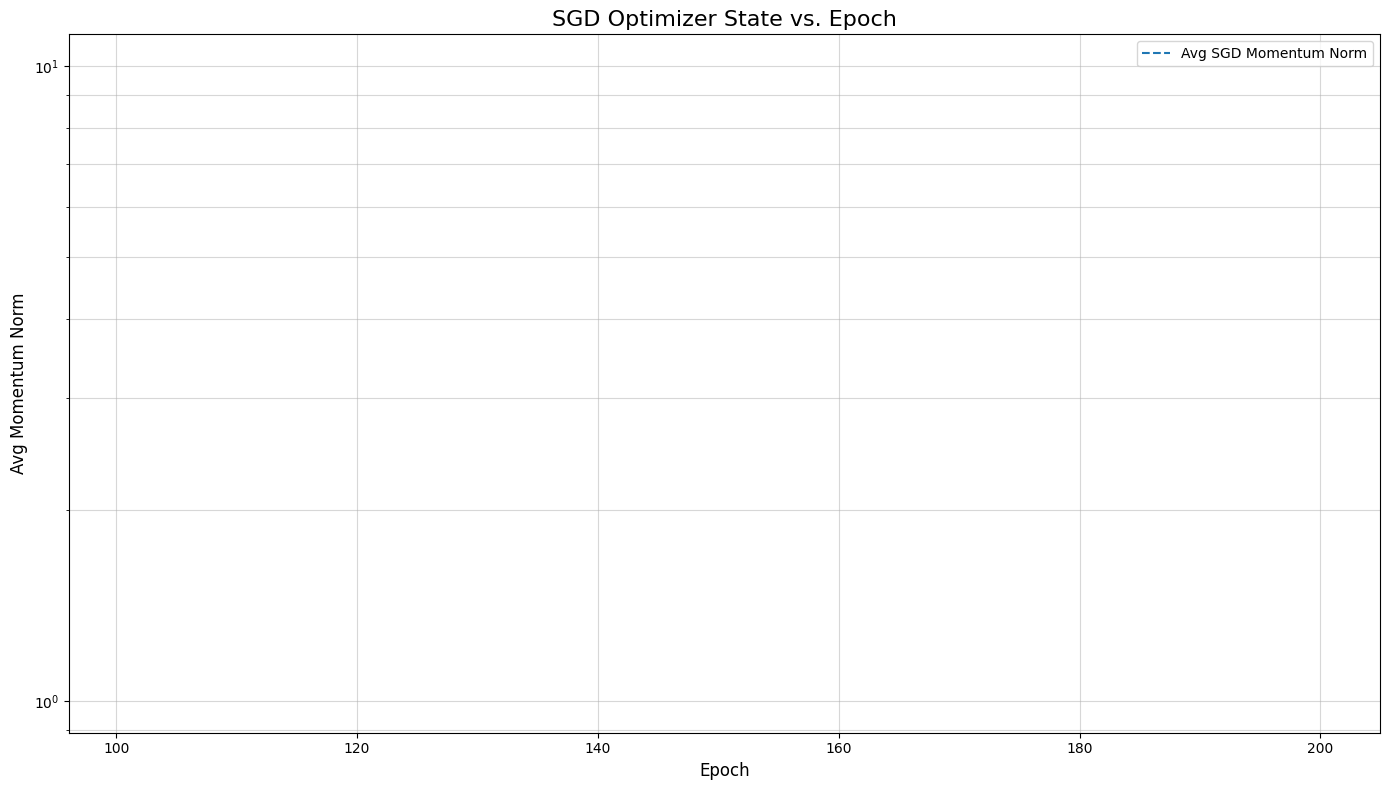

Saved plot: sgd_state_vs_epoch.png


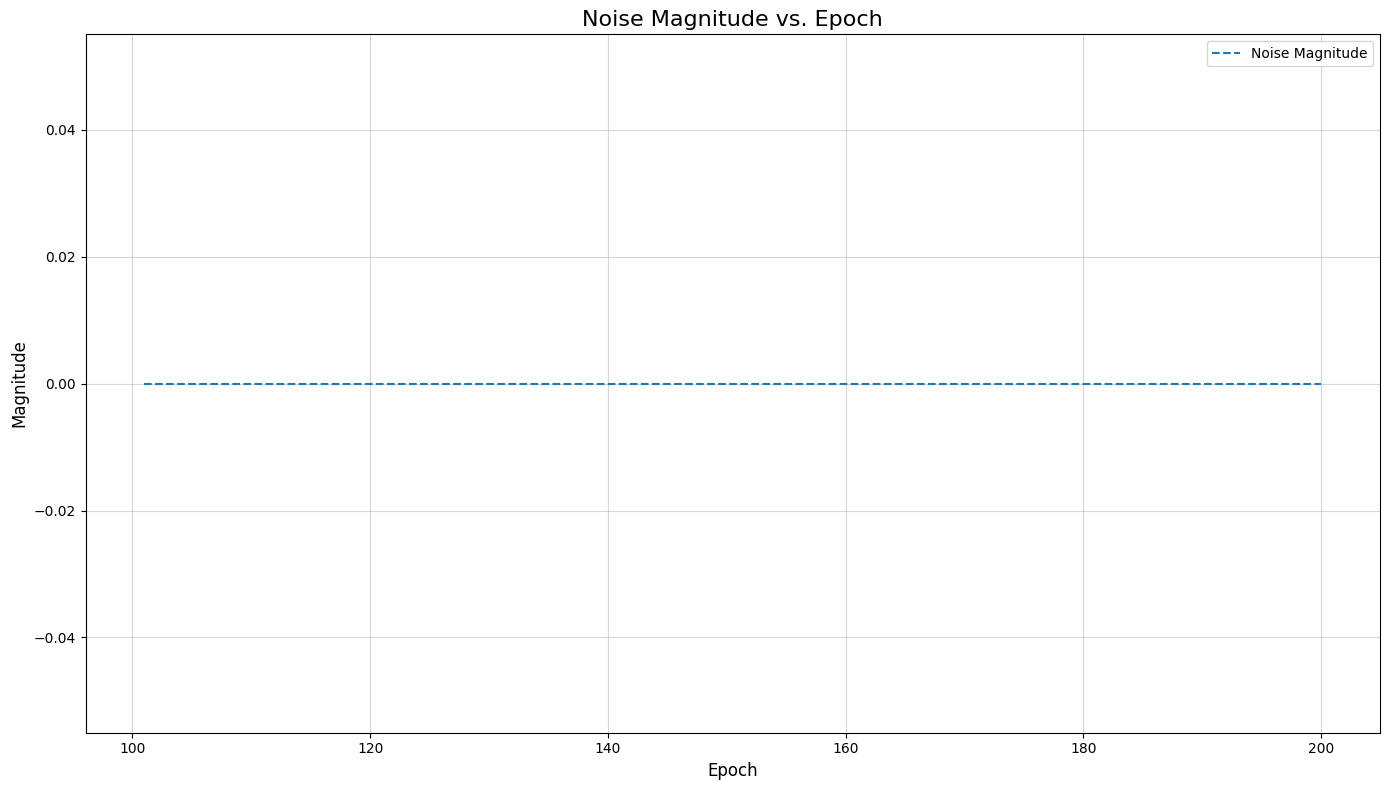

Saved plot: noise_magnitude_vs_epoch.png
Finished generating plots in my_experiment_plots.


In [2]:
json_file = r"C:\Users\Home\Documents\EPFL\OptML\OptML\PyTorch_CIFAR10\checkpoints\metrics\baby_cnn_none_20250609_190202\all_metrics.json" # <<< UPDATE THIS PATH
output_plot_dir = "my_experiment_plots" # Folder to save plots

# Create output directory if it doesn't exist
os.makedirs(output_plot_dir, exist_ok=True)
print(f"Loading metrics from: {json_file}")
print(f"Saving plots to: {output_plot_dir}")

# 2. Load and parse data
if not os.path.exists(json_file):
    print(f"Error: JSON file not found at {json_file}")
else:
    with open(json_file, 'r') as f:
        raw_data = json.load(f)

    epochs_data_dict = {}
    flags_history_list = []

    if isinstance(raw_data, dict):
        print(f"Info: Input file {json_file} is a dictionary. Parsing comprehensive metrics.")
        epochs_data_dict['epochs_completed'] = raw_data.get('epochs', [])
        epochs_data_dict['train_loss_history'] = raw_data.get('train_loss_history', [])
        epochs_data_dict['train_acc_history'] = raw_data.get('train_acc_history', [])
        epochs_data_dict['val_loss_history'] = raw_data.get('val_loss_history', [])
        epochs_data_dict['val_acc_history'] = raw_data.get('val_acc_history', [])
        epochs_data_dict['lr_history'] = raw_data.get('lr_history', [])
        flags_history_list = raw_data.get('optimization_flags_history', [])
        # Correctly extract noise metrics
        noise_metrics_history = raw_data.get('noise_metrics', [])

    elif isinstance(raw_data, list): # Fallback for older JSON structure if needed
        print(f"Info: Input file {json_file} is a list. This format might not contain all desired metrics.")
        epochs_data_dict['epochs_completed'] = [r.get("epoch") for r in raw_data if "epoch" in r]
        epochs_data_dict['train_loss_history'] = [r.get("train_loss") for r in raw_data if "train_loss" in r]
        epochs_data_dict['train_acc_history'] = [r.get("train_acc") for r in raw_data if "train_acc" in r]
        epochs_data_dict['val_loss_history'] = [r.get("val_loss") for r in raw_data if "val_loss" in r]
        epochs_data_dict['val_acc_history'] = [r.get("val_acc") for r in raw_data if "val_acc" in r]
        epochs_data_dict['lr_history'] = [r.get("learning_rate") for r in raw_data if "learning_rate" in r]
        noise_metrics_history = [] # No noise metrics in this older format, or handle specifically
        for key, val_list in epochs_data_dict.items():
            epochs_data_dict[key] = [v for v in val_list if v is not None]
    else:
        print(f"Error: Unknown JSON structure in {json_file}")
        # Exit or handle error appropriately if not running in a function
        exit()

    epochs = epochs_data_dict.get('epochs_completed', [])
    if not epochs:
        print("No epoch data found. Cannot generate plots.")
        exit() # Exit the script if no data

    num_epochs = len(epochs)
    epoch_ticks = np.array(epochs)

    train_loss = epochs_data_dict.get('train_loss_history', [])
    val_loss = epochs_data_dict.get('val_loss_history', [])
    train_acc = [a * 100 if isinstance(a, (int, float)) else float('nan') for a in epochs_data_dict.get('train_acc_history', [])]
    val_acc = [a * 100 if isinstance(a, (int, float)) else float('nan') for a in epochs_data_dict.get('val_acc_history', [])]
    lr_history = epochs_data_dict.get('lr_history', [])


    # Extract actual triggered flags
    flag_epochs_map: Dict[int, List[str]] = {}
    if flags_history_list:
        for flag_event in flags_history_list:
            epoch = flag_event.get('epoch')
            flag_type = flag_event.get('flag_type', 'UNKNOWN_FLAG')
            if epoch is not None:
                if epoch not in flag_epochs_map:
                    flag_epochs_map[epoch] = []
                if flag_type not in flag_epochs_map[epoch]:
                    flag_epochs_map[epoch].append(flag_type)
    else:
        print("No 'optimization_flags_history' found in JSON. Triggered flags from training will not be highlighted.")

    # Calculate metrics for plotting (even if not used for triggering)
    epoch_avg_grad_norms = _aggregate_batch_metric_per_epoch(raw_data.get('gradient_norms', []), epochs, 'total_norm')
    aligned_wu_norms = _align_epoch_metric(raw_data.get('weight_update_norm_history', []), epochs, 'norm')
    aligned_noise_mags = _align_epoch_metric(noise_metrics_history, epochs, 'magnitude') # Corrected source for noise magnitudes

    # 3. Generate Plots
    _plot_metric(1, "Training & Validation Loss vs. Epoch", "Loss",
                 epoch_ticks=epoch_ticks, num_epochs=num_epochs, output_dir=output_plot_dir, flag_epochs_map=flag_epochs_map,
                 train_metric=train_loss, val_metric=val_loss,
                 filename="loss_vs_epoch.png", log_scale_y=True)

    _plot_metric(2, "Training & Validation Accuracy vs. Epoch", "Accuracy (%)",
                 epoch_ticks=epoch_ticks, num_epochs=num_epochs, output_dir=output_plot_dir, flag_epochs_map=flag_epochs_map,
                 train_metric=train_acc, val_metric=val_acc,
                 filename="accuracy_vs_epoch.png")

    _plot_metric(3, "Learning Rate vs. Epoch", "Learning Rate",
                 epoch_ticks=epoch_ticks, num_epochs=num_epochs, output_dir=output_plot_dir, flag_epochs_map=flag_epochs_map,
                 other_metrics={"Learning Rate": lr_history},
                 filename="lr_vs_epoch.png", log_scale_y=True)

    if epoch_avg_grad_norms and any(not np.isnan(x) for x in epoch_avg_grad_norms):
        _plot_metric(4, "Average Gradient Norm vs. Epoch", "Avg L2 Norm of Gradients",
                     epoch_ticks=epoch_ticks, num_epochs=num_epochs, output_dir=output_plot_dir, flag_epochs_map=flag_epochs_map,
                     other_metrics={"Avg Grad Norm": epoch_avg_grad_norms},
                     filename="grad_norm_vs_epoch.png", log_scale_y=True)

    if aligned_wu_norms and any(not np.isnan(x) for x in aligned_wu_norms):
        _plot_metric(5, "Weight Update Norm vs. Epoch", "L2 Norm of Weight Updates",
                     epoch_ticks=epoch_ticks, num_epochs=num_epochs, output_dir=output_plot_dir, flag_epochs_map=flag_epochs_map,
                     other_metrics={"Weight Update Norm": aligned_wu_norms},
                     filename="weight_update_norm_vs_epoch.png", log_scale_y=True)

    optimizer_state_history = raw_data.get('optimizer_state_history', [])
    if optimizer_state_history:
        aligned_m_norms = _align_epoch_metric(optimizer_state_history, epochs, 'avg_m_norm')
        aligned_eff_lrs = _align_epoch_metric(optimizer_state_history, epochs, 'avg_eff_lr')
        aligned_momentum_norms = _align_epoch_metric(optimizer_state_history, epochs, 'avg_momentum_norm')

        adam_metrics_to_plot = {}
        if aligned_m_norms and any(not np.isnan(x) for x in aligned_m_norms): adam_metrics_to_plot['Avg Adam m_norm'] = aligned_m_norms
        if aligned_eff_lrs and any(not np.isnan(x) for x in aligned_eff_lrs): adam_metrics_to_plot['Avg Adam eff_LR'] = aligned_eff_lrs

        sgd_metrics_to_plot = {}
        if aligned_momentum_norms and any(not np.isnan(x) for x in aligned_momentum_norms): sgd_metrics_to_plot['Avg SGD Momentum Norm'] = aligned_momentum_norms

        if adam_metrics_to_plot:
            _plot_metric(6, "Adam Optimizer State vs. Epoch", "Metric Value",
                         epoch_ticks=epoch_ticks, num_epochs=num_epochs, output_dir=output_plot_dir, flag_epochs_map=flag_epochs_map,
                         other_metrics=adam_metrics_to_plot, filename="adam_state_vs_epoch.png", log_scale_y=True)
        if sgd_metrics_to_plot:
            _plot_metric(7, "SGD Optimizer State vs. Epoch", "Avg Momentum Norm",
                         epoch_ticks=epoch_ticks, num_epochs=num_epochs, output_dir=output_plot_dir, flag_epochs_map=flag_epochs_map,
                         other_metrics=sgd_metrics_to_plot, filename="sgd_state_vs_epoch.png", log_scale_y=True)

    if aligned_noise_mags and any(not np.isnan(x) for x in aligned_noise_mags):
        _plot_metric(8, "Noise Magnitude vs. Epoch", "Magnitude",
                     epoch_ticks=epoch_ticks, num_epochs=num_epochs, output_dir=output_plot_dir, flag_epochs_map=flag_epochs_map,
                     other_metrics={"Noise Magnitude": aligned_noise_mags},
                     filename="noise_magnitude_vs_epoch.png")


    print(f"Finished generating plots in {output_plot_dir}.")


Loading metrics from: C:\Users\Home\Documents\EPFL\OptML\OptML\PyTorch_CIFAR10\checkpoints\metrics\baby_cnn_gradient_gaussian_0.01_20250609_230947\all_metrics.json
Saving plots to: my_experiment_plots
Info: Input file C:\Users\Home\Documents\EPFL\OptML\OptML\PyTorch_CIFAR10\checkpoints\metrics\baby_cnn_gradient_gaussian_0.01_20250609_230947\all_metrics.json is a dictionary. Parsing comprehensive metrics.
No 'optimization_flags_history' found in JSON. Triggered flags from training will not be highlighted.


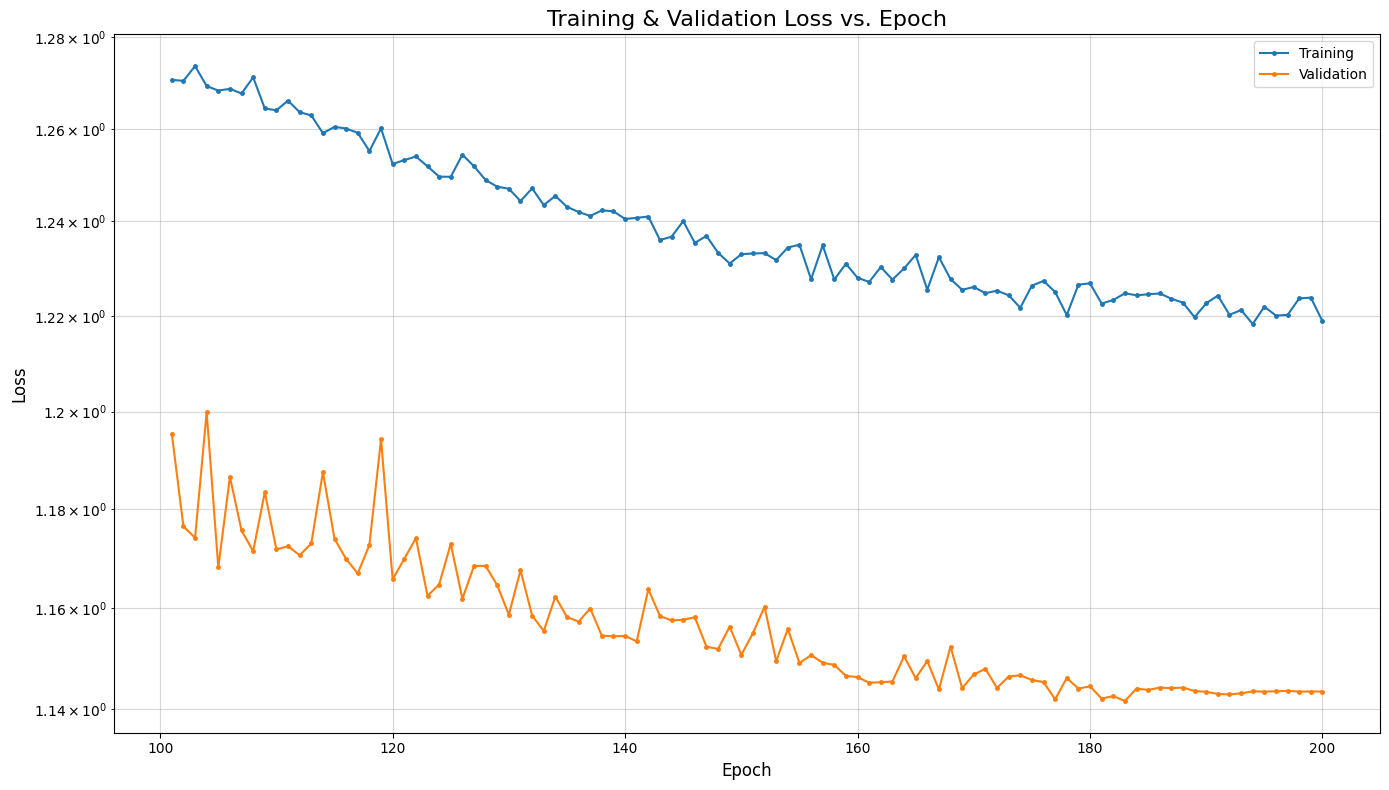

Saved plot: loss_vs_epoch.png


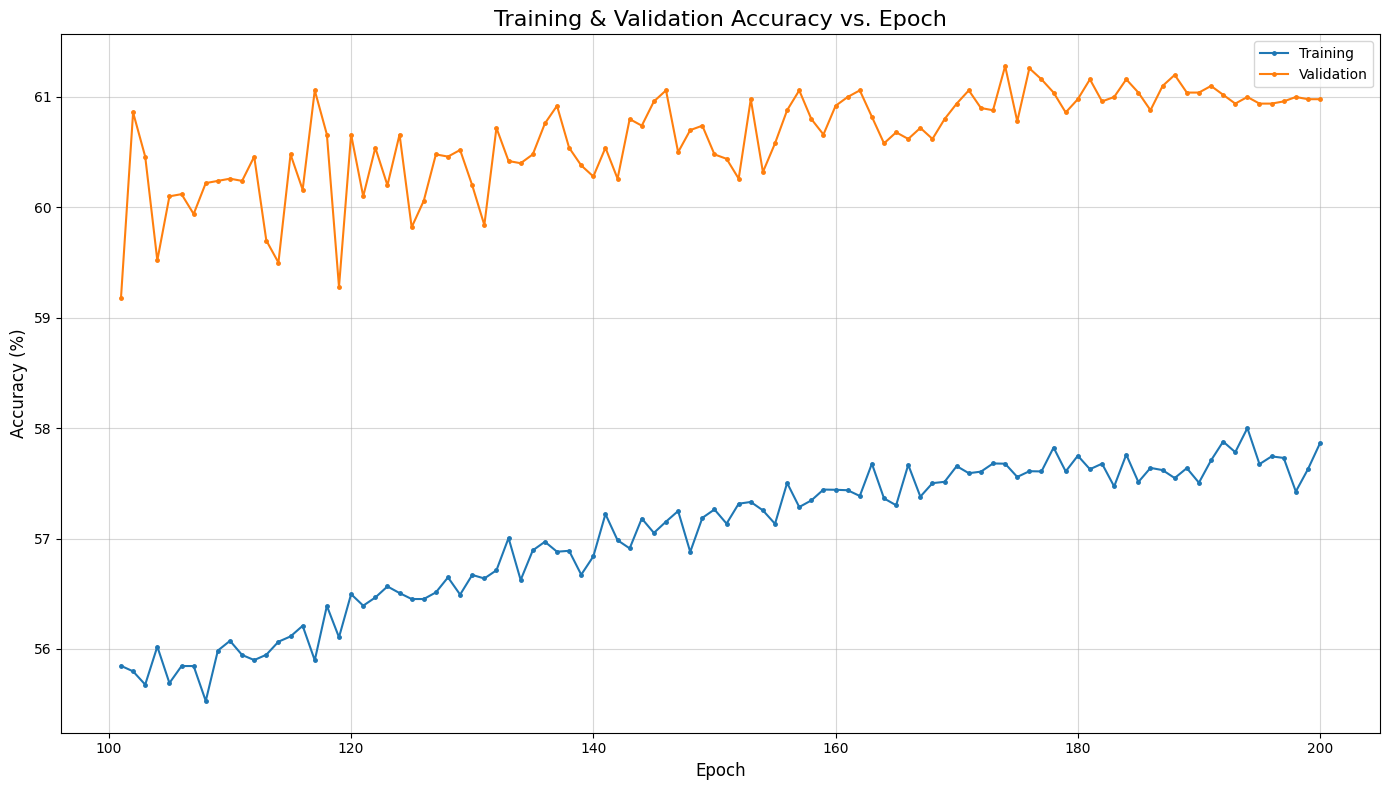

Saved plot: accuracy_vs_epoch.png


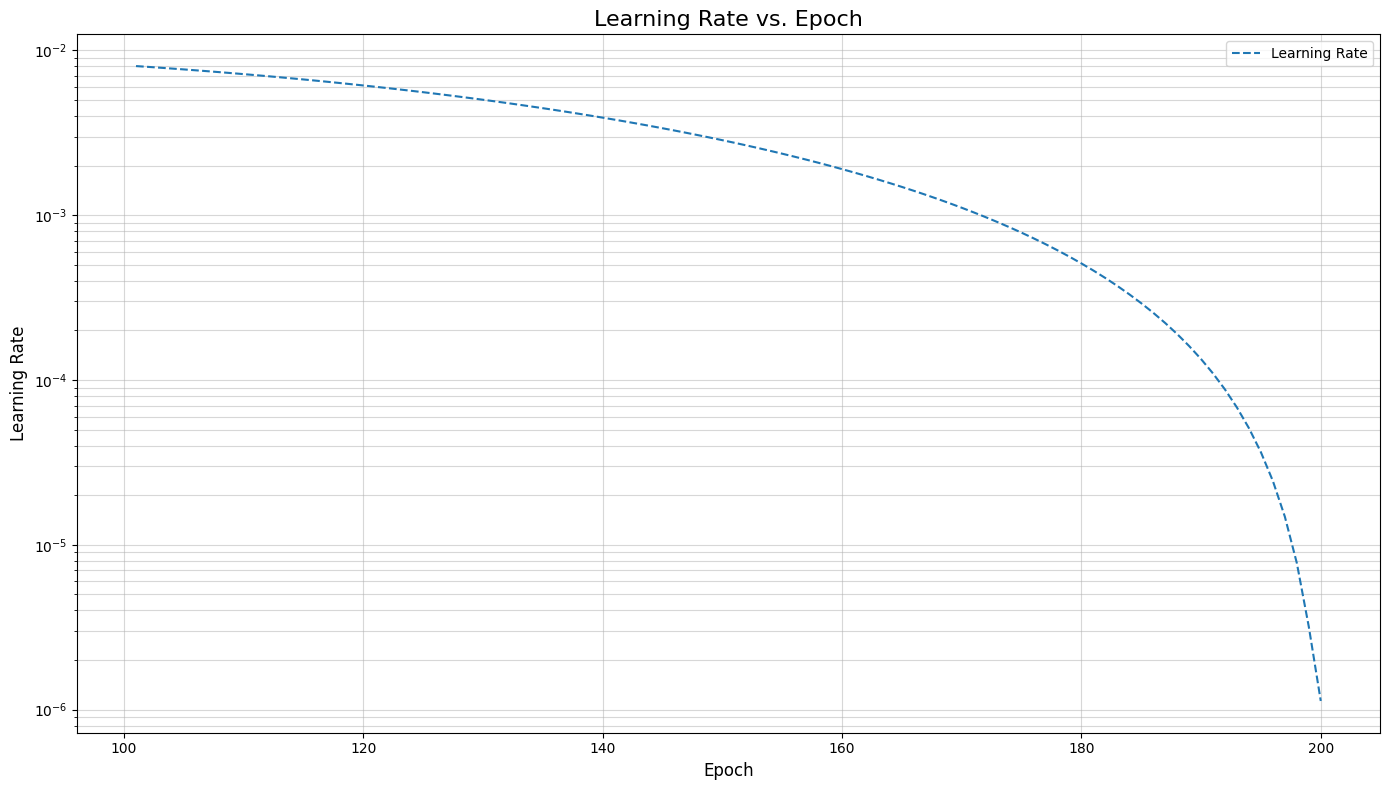

Saved plot: lr_vs_epoch.png


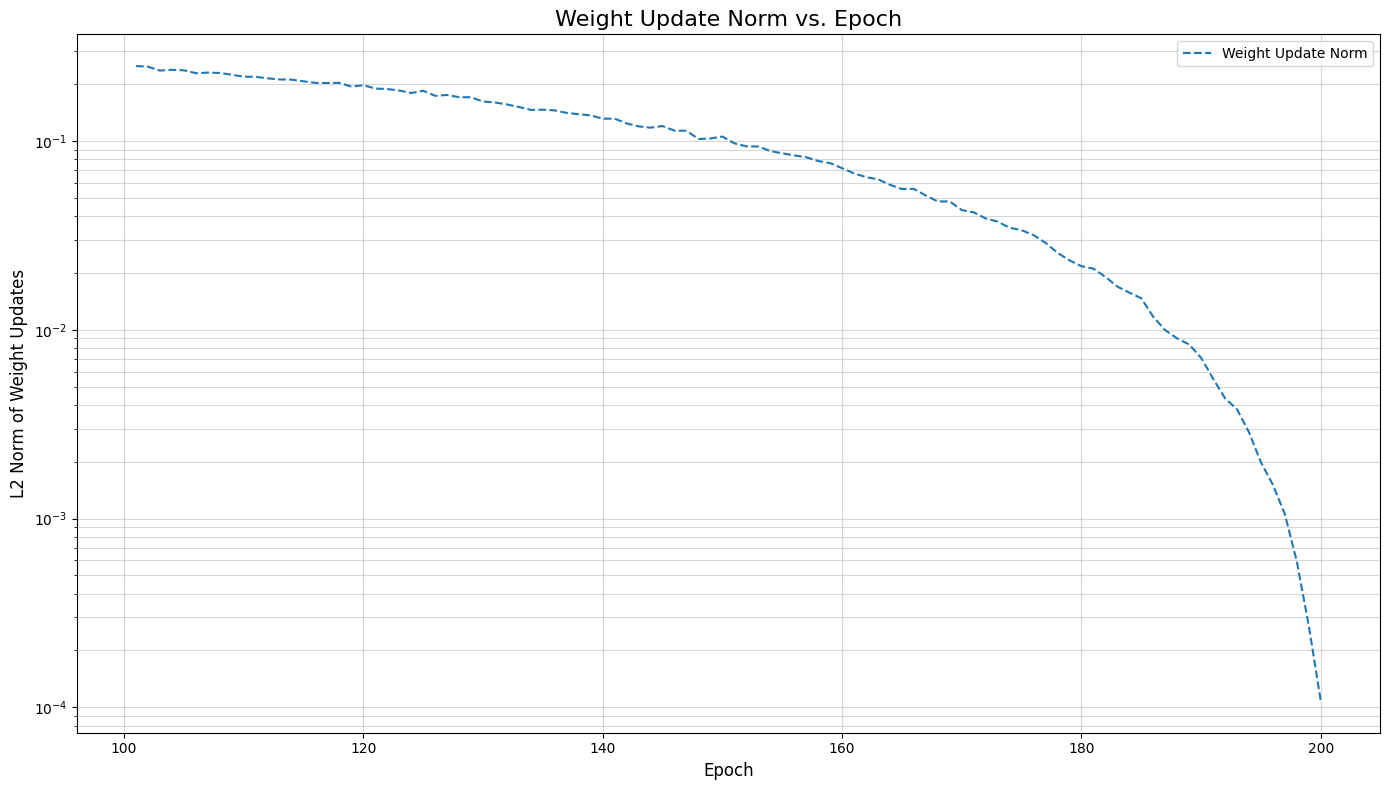

Saved plot: weight_update_norm_vs_epoch.png


C:\Users\Home\AppData\Local\Temp\ipykernel_22372\1715112738.py:104: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.yscale('log')


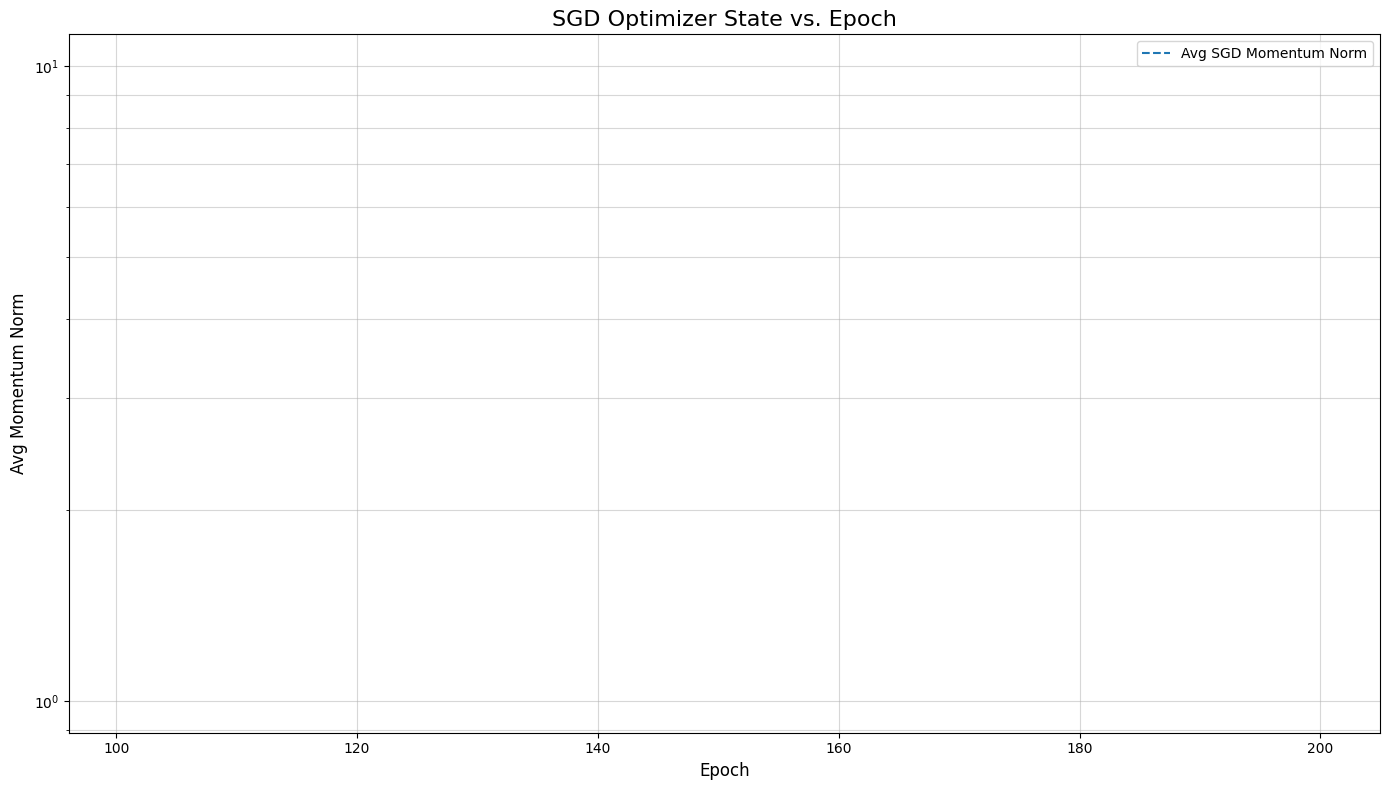

Saved plot: sgd_state_vs_epoch.png


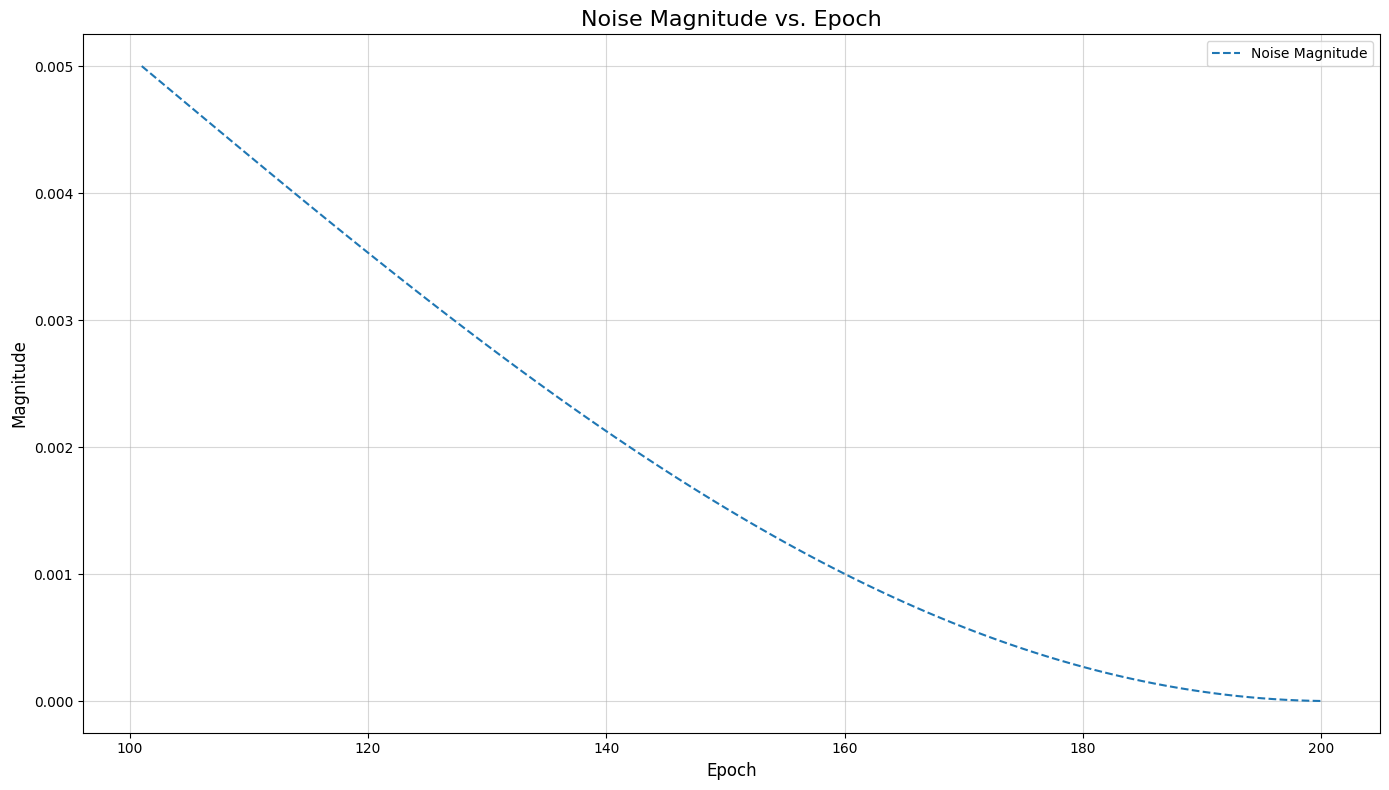

Saved plot: noise_magnitude_vs_epoch.png
Finished generating plots in my_experiment_plots.


In [5]:
json_file = r"C:\Users\Home\Documents\EPFL\OptML\OptML\PyTorch_CIFAR10\checkpoints\metrics\baby_cnn_gradient_gaussian_0.01_20250609_230947\all_metrics.json" # <<< UPDATE THIS PATH
output_plot_dir = "my_experiment_plots" # Folder to save plots

# Create output directory if it doesn't exist
os.makedirs(output_plot_dir, exist_ok=True)
print(f"Loading metrics from: {json_file}")
print(f"Saving plots to: {output_plot_dir}")

# 2. Load and parse data
if not os.path.exists(json_file):
    print(f"Error: JSON file not found at {json_file}")
else:
    with open(json_file, 'r') as f:
        raw_data = json.load(f)

    epochs_data_dict = {}
    flags_history_list = []

    if isinstance(raw_data, dict):
        print(f"Info: Input file {json_file} is a dictionary. Parsing comprehensive metrics.")
        epochs_data_dict['epochs_completed'] = raw_data.get('epochs', [])
        epochs_data_dict['train_loss_history'] = raw_data.get('train_loss_history', [])
        epochs_data_dict['train_acc_history'] = raw_data.get('train_acc_history', [])
        epochs_data_dict['val_loss_history'] = raw_data.get('val_loss_history', [])
        epochs_data_dict['val_acc_history'] = raw_data.get('val_acc_history', [])
        epochs_data_dict['lr_history'] = raw_data.get('lr_history', [])
        flags_history_list = raw_data.get('optimization_flags_history', [])
        # Correctly extract noise metrics
        noise_metrics_history = raw_data.get('noise_metrics', [])

    elif isinstance(raw_data, list): # Fallback for older JSON structure if needed
        print(f"Info: Input file {json_file} is a list. This format might not contain all desired metrics.")
        epochs_data_dict['epochs_completed'] = [r.get("epoch") for r in raw_data if "epoch" in r]
        epochs_data_dict['train_loss_history'] = [r.get("train_loss") for r in raw_data if "train_loss" in r]
        epochs_data_dict['train_acc_history'] = [r.get("train_acc") for r in raw_data if "train_acc" in r]
        epochs_data_dict['val_loss_history'] = [r.get("val_loss") for r in raw_data if "val_loss" in r]
        epochs_data_dict['val_acc_history'] = [r.get("val_acc") for r in raw_data if "val_acc" in r]
        epochs_data_dict['lr_history'] = [r.get("learning_rate") for r in raw_data if "learning_rate" in r]
        noise_metrics_history = [] # No noise metrics in this older format, or handle specifically
        for key, val_list in epochs_data_dict.items():
            epochs_data_dict[key] = [v for v in val_list if v is not None]
    else:
        print(f"Error: Unknown JSON structure in {json_file}")
        # Exit or handle error appropriately if not running in a function
        exit()

    epochs = epochs_data_dict.get('epochs_completed', [])
    if not epochs:
        print("No epoch data found. Cannot generate plots.")
        exit() # Exit the script if no data

    num_epochs = len(epochs)
    epoch_ticks = np.array(epochs)

    train_loss = epochs_data_dict.get('train_loss_history', [])
    val_loss = epochs_data_dict.get('val_loss_history', [])
    train_acc = [a * 100 if isinstance(a, (int, float)) else float('nan') for a in epochs_data_dict.get('train_acc_history', [])]
    val_acc = [a * 100 if isinstance(a, (int, float)) else float('nan') for a in epochs_data_dict.get('val_acc_history', [])]
    lr_history = epochs_data_dict.get('lr_history', [])


    # Extract actual triggered flags
    flag_epochs_map: Dict[int, List[str]] = {}
    if flags_history_list:
        for flag_event in flags_history_list:
            epoch = flag_event.get('epoch')
            flag_type = flag_event.get('flag_type', 'UNKNOWN_FLAG')
            if epoch is not None:
                if epoch not in flag_epochs_map:
                    flag_epochs_map[epoch] = []
                if flag_type not in flag_epochs_map[epoch]:
                    flag_epochs_map[epoch].append(flag_type)
    else:
        print("No 'optimization_flags_history' found in JSON. Triggered flags from training will not be highlighted.")

    # Calculate metrics for plotting (even if not used for triggering)
    epoch_avg_grad_norms = _aggregate_batch_metric_per_epoch(raw_data.get('gradient_norms', []), epochs, 'total_norm')
    aligned_wu_norms = _align_epoch_metric(raw_data.get('weight_update_norm_history', []), epochs, 'norm')
    aligned_noise_mags = _align_epoch_metric(noise_metrics_history, epochs, 'magnitude') # Corrected source for noise magnitudes

    # 3. Generate Plots
    _plot_metric(1, "Training & Validation Loss vs. Epoch", "Loss",
                 epoch_ticks=epoch_ticks, num_epochs=num_epochs, output_dir=output_plot_dir, flag_epochs_map=flag_epochs_map,
                 train_metric=train_loss, val_metric=val_loss,
                 filename="loss_vs_epoch.png", log_scale_y=True)

    _plot_metric(2, "Training & Validation Accuracy vs. Epoch", "Accuracy (%)",
                 epoch_ticks=epoch_ticks, num_epochs=num_epochs, output_dir=output_plot_dir, flag_epochs_map=flag_epochs_map,
                 train_metric=train_acc, val_metric=val_acc,
                 filename="accuracy_vs_epoch.png")

    _plot_metric(3, "Learning Rate vs. Epoch", "Learning Rate",
                 epoch_ticks=epoch_ticks, num_epochs=num_epochs, output_dir=output_plot_dir, flag_epochs_map=flag_epochs_map,
                 other_metrics={"Learning Rate": lr_history},
                 filename="lr_vs_epoch.png", log_scale_y=True)

    if epoch_avg_grad_norms and any(not np.isnan(x) for x in epoch_avg_grad_norms):
        _plot_metric(4, "Average Gradient Norm vs. Epoch", "Avg L2 Norm of Gradients",
                     epoch_ticks=epoch_ticks, num_epochs=num_epochs, output_dir=output_plot_dir, flag_epochs_map=flag_epochs_map,
                     other_metrics={"Avg Grad Norm": epoch_avg_grad_norms},
                     filename="grad_norm_vs_epoch.png", log_scale_y=True)

    if aligned_wu_norms and any(not np.isnan(x) for x in aligned_wu_norms):
        _plot_metric(5, "Weight Update Norm vs. Epoch", "L2 Norm of Weight Updates",
                     epoch_ticks=epoch_ticks, num_epochs=num_epochs, output_dir=output_plot_dir, flag_epochs_map=flag_epochs_map,
                     other_metrics={"Weight Update Norm": aligned_wu_norms},
                     filename="weight_update_norm_vs_epoch.png", log_scale_y=True)

    optimizer_state_history = raw_data.get('optimizer_state_history', [])
    if optimizer_state_history:
        aligned_m_norms = _align_epoch_metric(optimizer_state_history, epochs, 'avg_m_norm')
        aligned_eff_lrs = _align_epoch_metric(optimizer_state_history, epochs, 'avg_eff_lr')
        aligned_momentum_norms = _align_epoch_metric(optimizer_state_history, epochs, 'avg_momentum_norm')

        adam_metrics_to_plot = {}
        if aligned_m_norms and any(not np.isnan(x) for x in aligned_m_norms): adam_metrics_to_plot['Avg Adam m_norm'] = aligned_m_norms
        if aligned_eff_lrs and any(not np.isnan(x) for x in aligned_eff_lrs): adam_metrics_to_plot['Avg Adam eff_LR'] = aligned_eff_lrs

        sgd_metrics_to_plot = {}
        if aligned_momentum_norms and any(not np.isnan(x) for x in aligned_momentum_norms): sgd_metrics_to_plot['Avg SGD Momentum Norm'] = aligned_momentum_norms

        if adam_metrics_to_plot:
            _plot_metric(6, "Adam Optimizer State vs. Epoch", "Metric Value",
                         epoch_ticks=epoch_ticks, num_epochs=num_epochs, output_dir=output_plot_dir, flag_epochs_map=flag_epochs_map,
                         other_metrics=adam_metrics_to_plot, filename="adam_state_vs_epoch.png", log_scale_y=True)
        if sgd_metrics_to_plot:
            _plot_metric(7, "SGD Optimizer State vs. Epoch", "Avg Momentum Norm",
                         epoch_ticks=epoch_ticks, num_epochs=num_epochs, output_dir=output_plot_dir, flag_epochs_map=flag_epochs_map,
                         other_metrics=sgd_metrics_to_plot, filename="sgd_state_vs_epoch.png", log_scale_y=True)

    if aligned_noise_mags and any(not np.isnan(x) for x in aligned_noise_mags):
        _plot_metric(8, "Noise Magnitude vs. Epoch", "Magnitude",
                     epoch_ticks=epoch_ticks, num_epochs=num_epochs, output_dir=output_plot_dir, flag_epochs_map=flag_epochs_map,
                     other_metrics={"Noise Magnitude": aligned_noise_mags},
                     filename="noise_magnitude_vs_epoch.png")


    print(f"Finished generating plots in {output_plot_dir}.")


Loading metrics from: C:\Users\Home\Documents\EPFL\OptML\OptML\PyTorch_CIFAR10\checkpoints\metrics\baby_cnn_gradient_gaussian_0.01_20250609_193813\all_metrics.json
Saving plots to: my_experiment_plots
Info: Input file C:\Users\Home\Documents\EPFL\OptML\OptML\PyTorch_CIFAR10\checkpoints\metrics\baby_cnn_gradient_gaussian_0.01_20250609_193813\all_metrics.json is a dictionary. Parsing comprehensive metrics.
No 'optimization_flags_history' found in JSON. Triggered flags from training will not be highlighted.


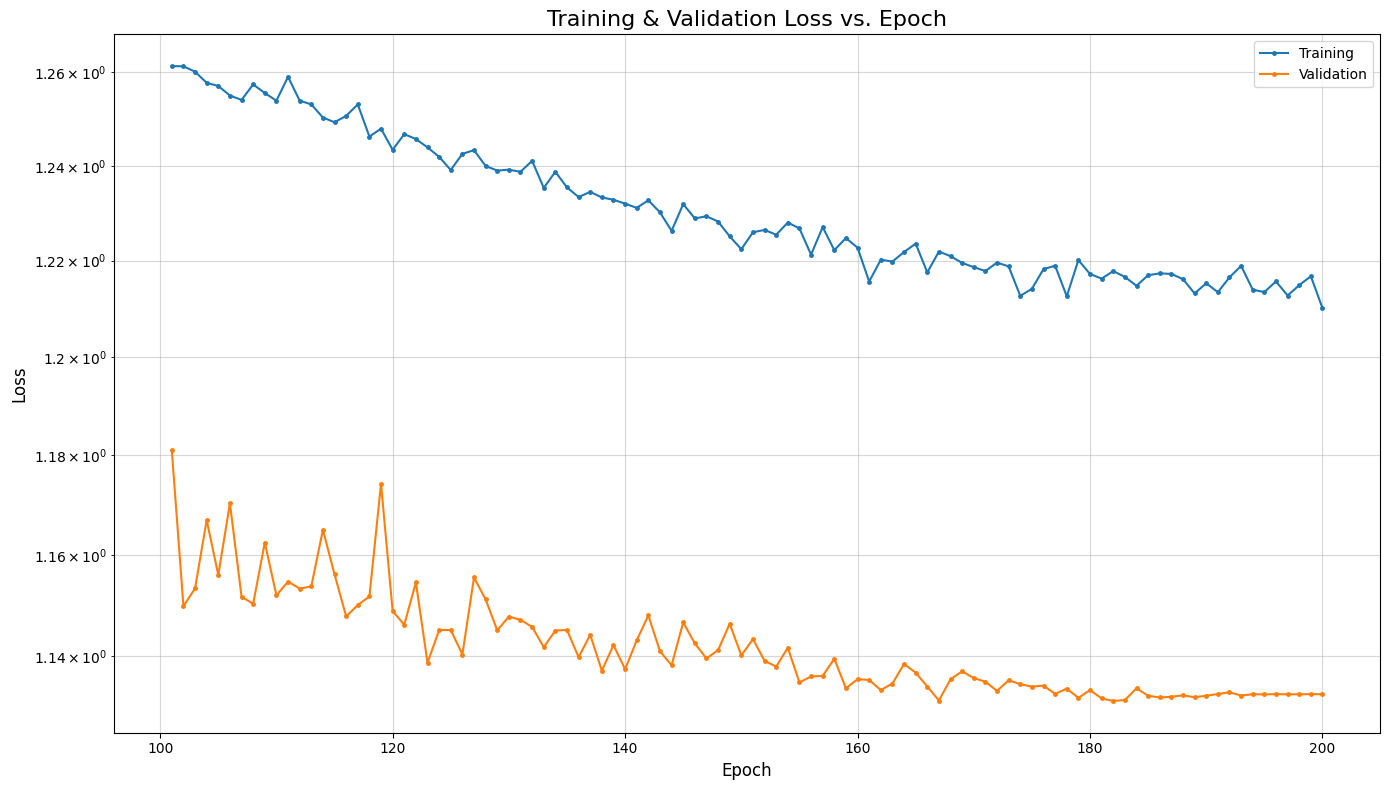

Saved plot: loss_vs_epoch.png


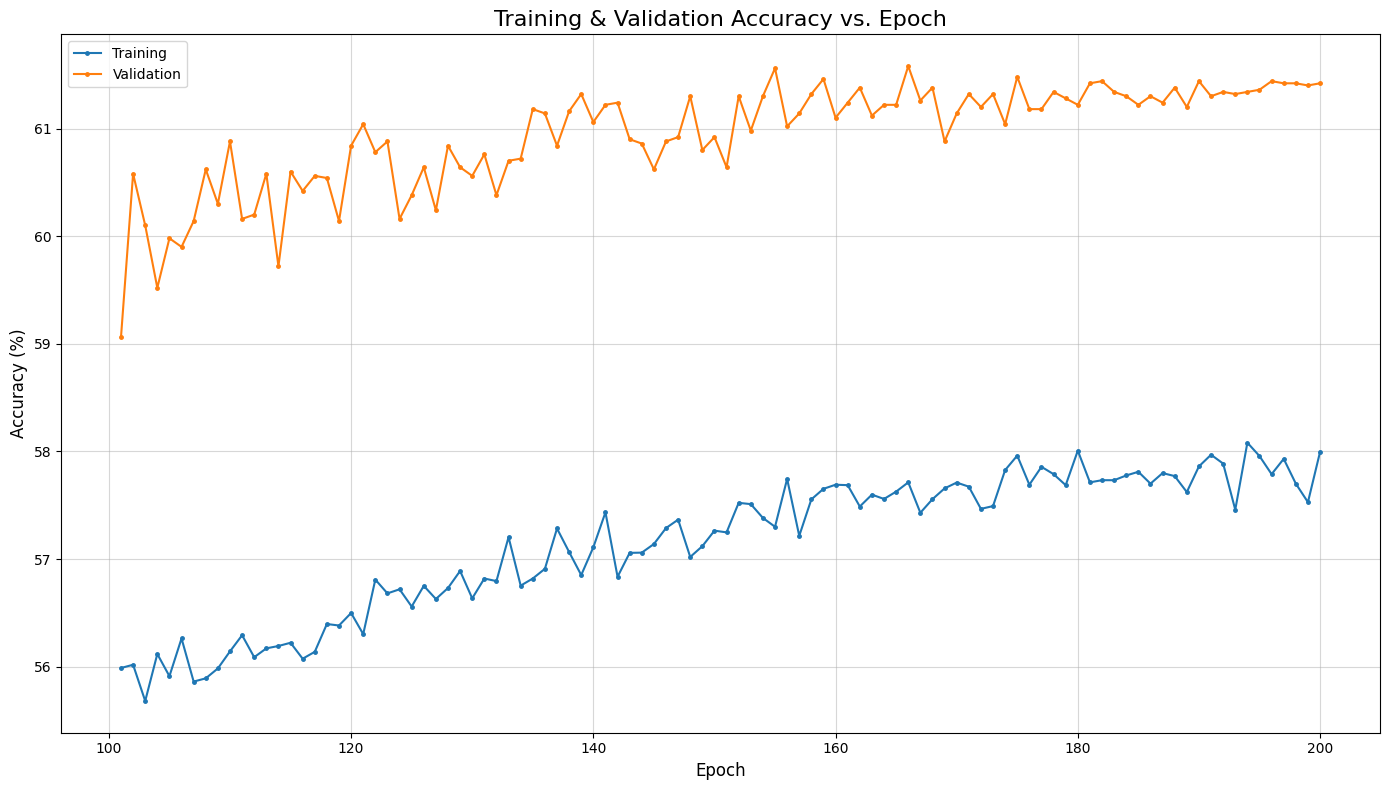

Saved plot: accuracy_vs_epoch.png


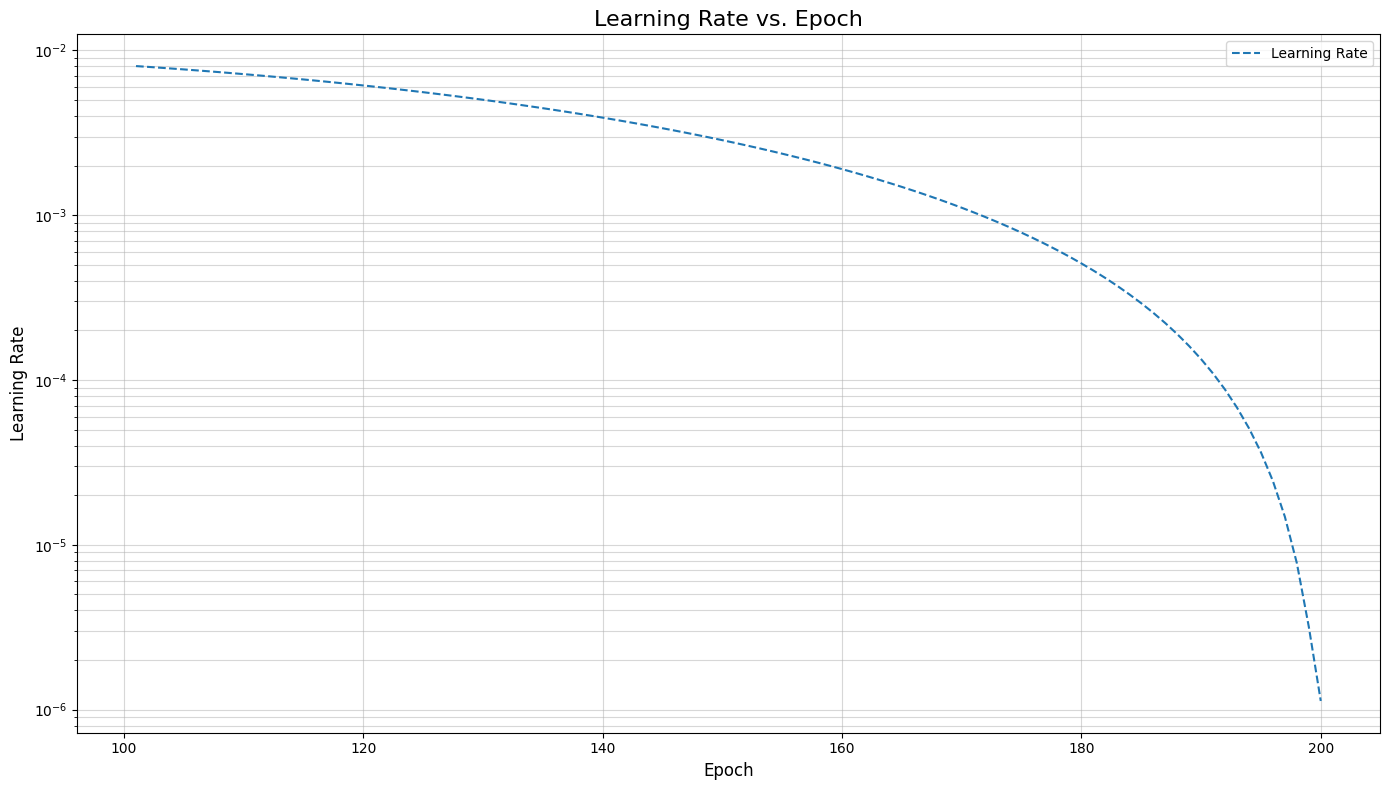

Saved plot: lr_vs_epoch.png


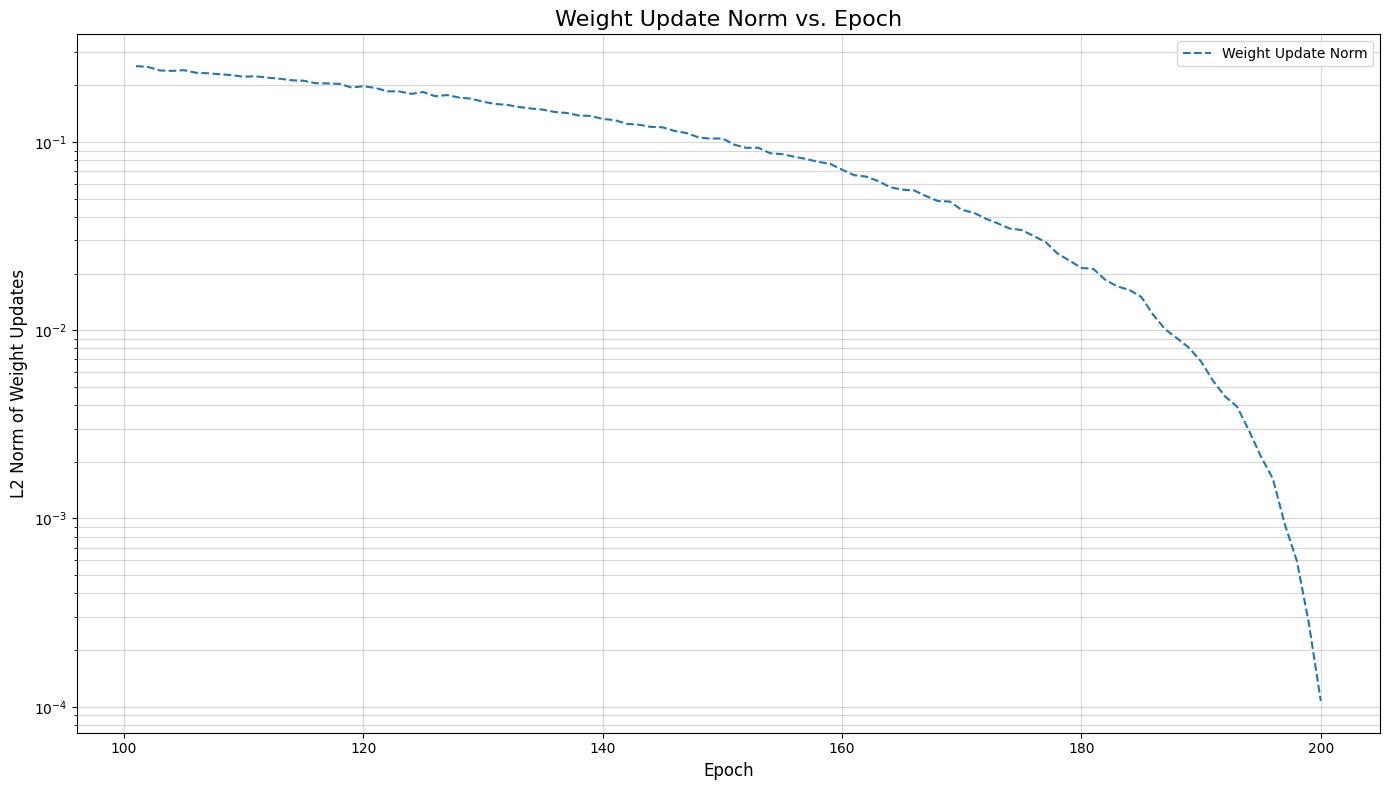

Saved plot: weight_update_norm_vs_epoch.png


C:\Users\Home\AppData\Local\Temp\ipykernel_22372\1715112738.py:104: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.yscale('log')


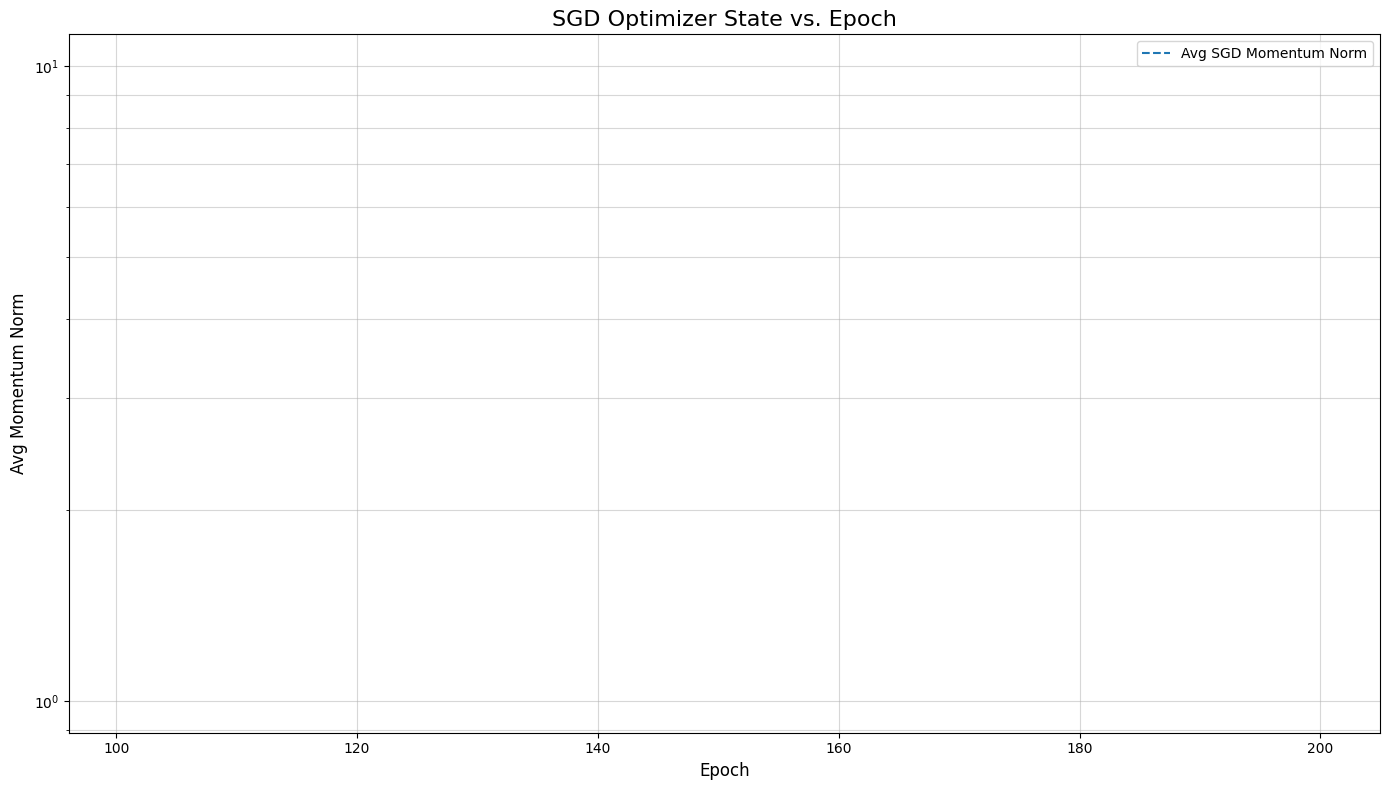

Saved plot: sgd_state_vs_epoch.png


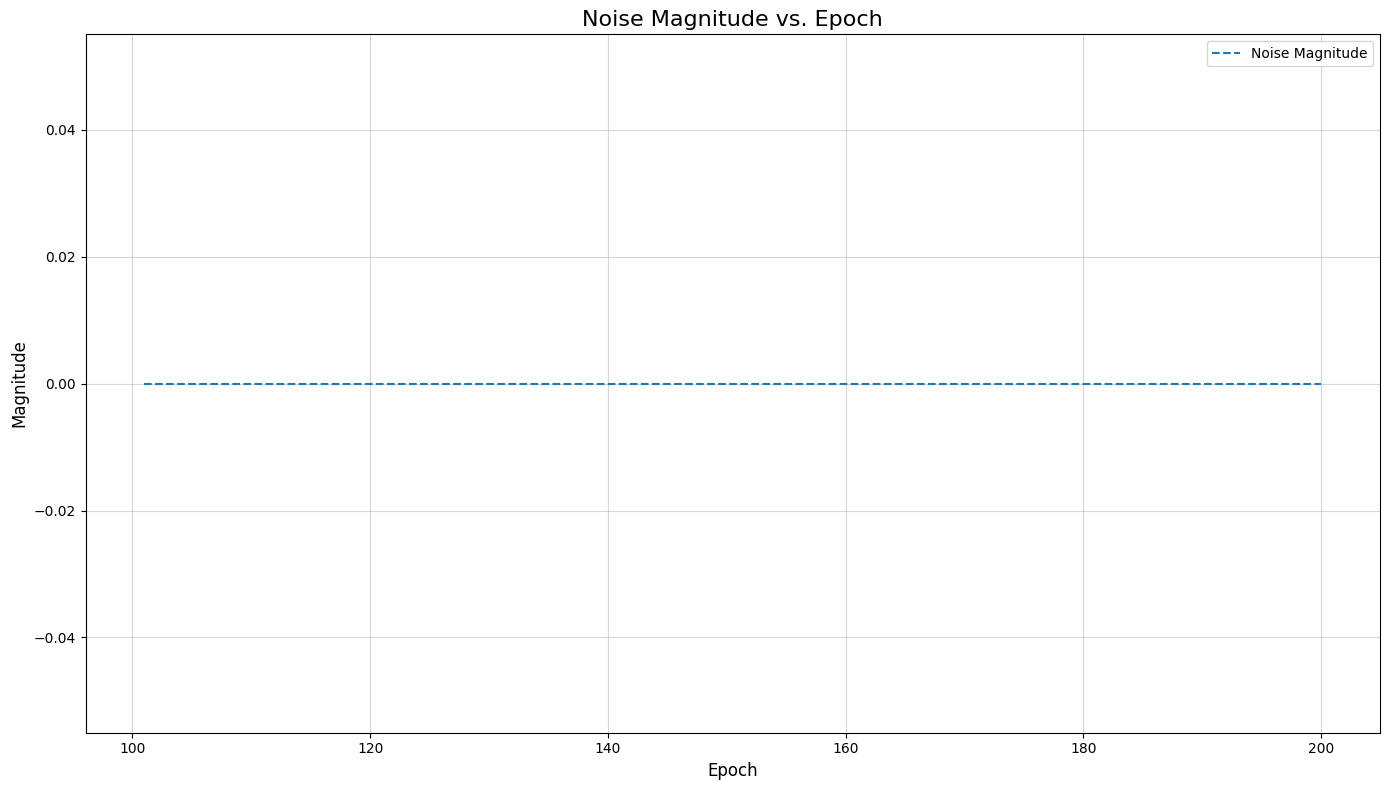

Saved plot: noise_magnitude_vs_epoch.png
Finished generating plots in my_experiment_plots.


In [4]:
json_file = r"C:\Users\Home\Documents\EPFL\OptML\OptML\PyTorch_CIFAR10\checkpoints\metrics\baby_cnn_gradient_gaussian_0.01_20250609_193813\all_metrics.json" # <<< UPDATE THIS PATH
output_plot_dir = "my_experiment_plots" # Folder to save plots

# Create output directory if it doesn't exist
os.makedirs(output_plot_dir, exist_ok=True)
print(f"Loading metrics from: {json_file}")
print(f"Saving plots to: {output_plot_dir}")

# 2. Load and parse data
if not os.path.exists(json_file):
    print(f"Error: JSON file not found at {json_file}")
else:
    with open(json_file, 'r') as f:
        raw_data = json.load(f)

    epochs_data_dict = {}
    flags_history_list = []

    if isinstance(raw_data, dict):
        print(f"Info: Input file {json_file} is a dictionary. Parsing comprehensive metrics.")
        epochs_data_dict['epochs_completed'] = raw_data.get('epochs', [])
        epochs_data_dict['train_loss_history'] = raw_data.get('train_loss_history', [])
        epochs_data_dict['train_acc_history'] = raw_data.get('train_acc_history', [])
        epochs_data_dict['val_loss_history'] = raw_data.get('val_loss_history', [])
        epochs_data_dict['val_acc_history'] = raw_data.get('val_acc_history', [])
        epochs_data_dict['lr_history'] = raw_data.get('lr_history', [])
        flags_history_list = raw_data.get('optimization_flags_history', [])
        # Correctly extract noise metrics
        noise_metrics_history = raw_data.get('noise_metrics', [])

    elif isinstance(raw_data, list): # Fallback for older JSON structure if needed
        print(f"Info: Input file {json_file} is a list. This format might not contain all desired metrics.")
        epochs_data_dict['epochs_completed'] = [r.get("epoch") for r in raw_data if "epoch" in r]
        epochs_data_dict['train_loss_history'] = [r.get("train_loss") for r in raw_data if "train_loss" in r]
        epochs_data_dict['train_acc_history'] = [r.get("train_acc") for r in raw_data if "train_acc" in r]
        epochs_data_dict['val_loss_history'] = [r.get("val_loss") for r in raw_data if "val_loss" in r]
        epochs_data_dict['val_acc_history'] = [r.get("val_acc") for r in raw_data if "val_acc" in r]
        epochs_data_dict['lr_history'] = [r.get("learning_rate") for r in raw_data if "learning_rate" in r]
        noise_metrics_history = [] # No noise metrics in this older format, or handle specifically
        for key, val_list in epochs_data_dict.items():
            epochs_data_dict[key] = [v for v in val_list if v is not None]
    else:
        print(f"Error: Unknown JSON structure in {json_file}")
        # Exit or handle error appropriately if not running in a function
        exit()

    epochs = epochs_data_dict.get('epochs_completed', [])
    if not epochs:
        print("No epoch data found. Cannot generate plots.")
        exit() # Exit the script if no data

    num_epochs = len(epochs)
    epoch_ticks = np.array(epochs)

    train_loss = epochs_data_dict.get('train_loss_history', [])
    val_loss = epochs_data_dict.get('val_loss_history', [])
    train_acc = [a * 100 if isinstance(a, (int, float)) else float('nan') for a in epochs_data_dict.get('train_acc_history', [])]
    val_acc = [a * 100 if isinstance(a, (int, float)) else float('nan') for a in epochs_data_dict.get('val_acc_history', [])]
    lr_history = epochs_data_dict.get('lr_history', [])


    # Extract actual triggered flags
    flag_epochs_map: Dict[int, List[str]] = {}
    if flags_history_list:
        for flag_event in flags_history_list:
            epoch = flag_event.get('epoch')
            flag_type = flag_event.get('flag_type', 'UNKNOWN_FLAG')
            if epoch is not None:
                if epoch not in flag_epochs_map:
                    flag_epochs_map[epoch] = []
                if flag_type not in flag_epochs_map[epoch]:
                    flag_epochs_map[epoch].append(flag_type)
    else:
        print("No 'optimization_flags_history' found in JSON. Triggered flags from training will not be highlighted.")

    # Calculate metrics for plotting (even if not used for triggering)
    epoch_avg_grad_norms = _aggregate_batch_metric_per_epoch(raw_data.get('gradient_norms', []), epochs, 'total_norm')
    aligned_wu_norms = _align_epoch_metric(raw_data.get('weight_update_norm_history', []), epochs, 'norm')
    aligned_noise_mags = _align_epoch_metric(noise_metrics_history, epochs, 'magnitude') # Corrected source for noise magnitudes

    # 3. Generate Plots
    _plot_metric(1, "Training & Validation Loss vs. Epoch", "Loss",
                 epoch_ticks=epoch_ticks, num_epochs=num_epochs, output_dir=output_plot_dir, flag_epochs_map=flag_epochs_map,
                 train_metric=train_loss, val_metric=val_loss,
                 filename="loss_vs_epoch.png", log_scale_y=True)

    _plot_metric(2, "Training & Validation Accuracy vs. Epoch", "Accuracy (%)",
                 epoch_ticks=epoch_ticks, num_epochs=num_epochs, output_dir=output_plot_dir, flag_epochs_map=flag_epochs_map,
                 train_metric=train_acc, val_metric=val_acc,
                 filename="accuracy_vs_epoch.png")

    _plot_metric(3, "Learning Rate vs. Epoch", "Learning Rate",
                 epoch_ticks=epoch_ticks, num_epochs=num_epochs, output_dir=output_plot_dir, flag_epochs_map=flag_epochs_map,
                 other_metrics={"Learning Rate": lr_history},
                 filename="lr_vs_epoch.png", log_scale_y=True)

    if epoch_avg_grad_norms and any(not np.isnan(x) for x in epoch_avg_grad_norms):
        _plot_metric(4, "Average Gradient Norm vs. Epoch", "Avg L2 Norm of Gradients",
                     epoch_ticks=epoch_ticks, num_epochs=num_epochs, output_dir=output_plot_dir, flag_epochs_map=flag_epochs_map,
                     other_metrics={"Avg Grad Norm": epoch_avg_grad_norms},
                     filename="grad_norm_vs_epoch.png", log_scale_y=True)

    if aligned_wu_norms and any(not np.isnan(x) for x in aligned_wu_norms):
        _plot_metric(5, "Weight Update Norm vs. Epoch", "L2 Norm of Weight Updates",
                     epoch_ticks=epoch_ticks, num_epochs=num_epochs, output_dir=output_plot_dir, flag_epochs_map=flag_epochs_map,
                     other_metrics={"Weight Update Norm": aligned_wu_norms},
                     filename="weight_update_norm_vs_epoch.png", log_scale_y=True)

    optimizer_state_history = raw_data.get('optimizer_state_history', [])
    if optimizer_state_history:
        aligned_m_norms = _align_epoch_metric(optimizer_state_history, epochs, 'avg_m_norm')
        aligned_eff_lrs = _align_epoch_metric(optimizer_state_history, epochs, 'avg_eff_lr')
        aligned_momentum_norms = _align_epoch_metric(optimizer_state_history, epochs, 'avg_momentum_norm')

        adam_metrics_to_plot = {}
        if aligned_m_norms and any(not np.isnan(x) for x in aligned_m_norms): adam_metrics_to_plot['Avg Adam m_norm'] = aligned_m_norms
        if aligned_eff_lrs and any(not np.isnan(x) for x in aligned_eff_lrs): adam_metrics_to_plot['Avg Adam eff_LR'] = aligned_eff_lrs

        sgd_metrics_to_plot = {}
        if aligned_momentum_norms and any(not np.isnan(x) for x in aligned_momentum_norms): sgd_metrics_to_plot['Avg SGD Momentum Norm'] = aligned_momentum_norms

        if adam_metrics_to_plot:
            _plot_metric(6, "Adam Optimizer State vs. Epoch", "Metric Value",
                         epoch_ticks=epoch_ticks, num_epochs=num_epochs, output_dir=output_plot_dir, flag_epochs_map=flag_epochs_map,
                         other_metrics=adam_metrics_to_plot, filename="adam_state_vs_epoch.png", log_scale_y=True)
        if sgd_metrics_to_plot:
            _plot_metric(7, "SGD Optimizer State vs. Epoch", "Avg Momentum Norm",
                         epoch_ticks=epoch_ticks, num_epochs=num_epochs, output_dir=output_plot_dir, flag_epochs_map=flag_epochs_map,
                         other_metrics=sgd_metrics_to_plot, filename="sgd_state_vs_epoch.png", log_scale_y=True)

    if aligned_noise_mags and any(not np.isnan(x) for x in aligned_noise_mags):
        _plot_metric(8, "Noise Magnitude vs. Epoch", "Magnitude",
                     epoch_ticks=epoch_ticks, num_epochs=num_epochs, output_dir=output_plot_dir, flag_epochs_map=flag_epochs_map,
                     other_metrics={"Noise Magnitude": aligned_noise_mags},
                     filename="noise_magnitude_vs_epoch.png")


    print(f"Finished generating plots in {output_plot_dir}.")


Successfully loaded 5 flag events from C:\Users\Home\Documents\EPFL\OptML\OptML\PyTorch_CIFAR10\checkpoints\metrics\baby_cnn_gradient_gaussian_0.01_20250610_212152\optimization_flags.jsonl
Successfully loaded gradient norm data for 200 epochs from C:\Users\Home\Documents\EPFL\OptML\OptML\PyTorch_CIFAR10\checkpoints\metrics\baby_cnn_gradient_gaussian_0.01_20250610_212152\all_metrics.json
Successfully loaded epoch data for 200 epochs.


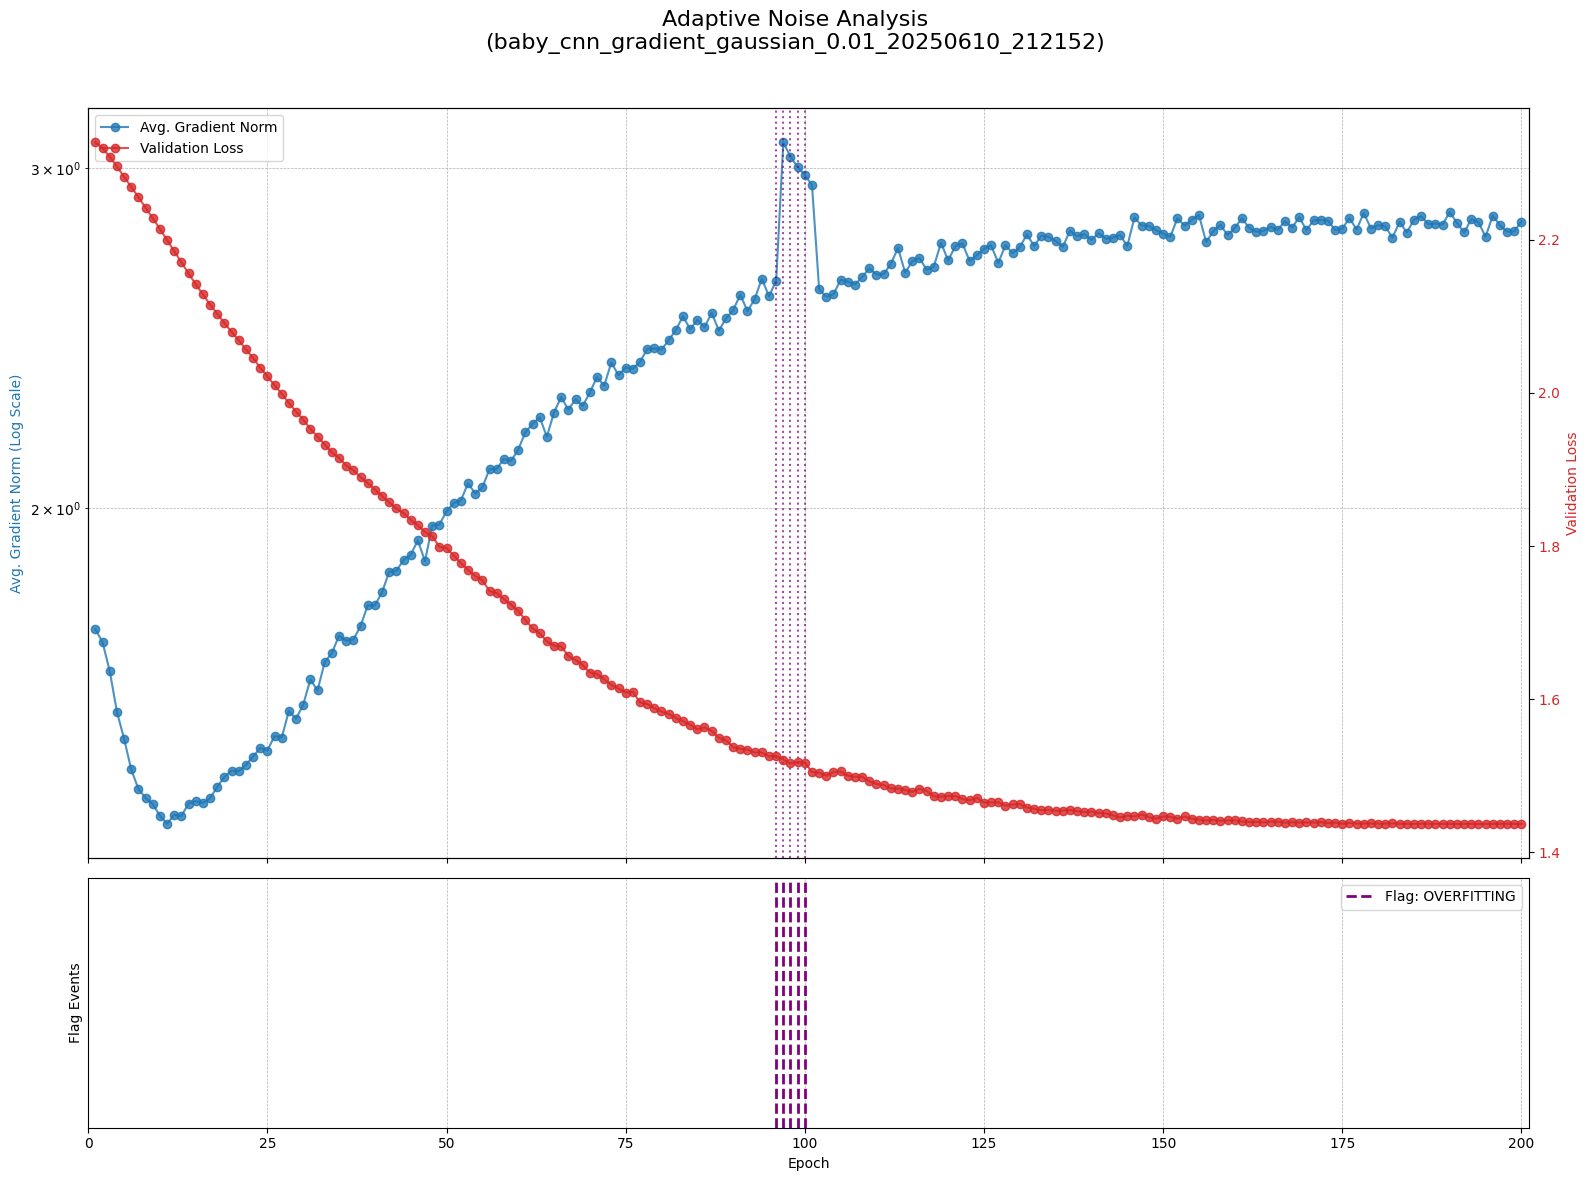

In [1]:
import json
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def plot_adaptive_noise_analysis(experiment_dir: str):
    """
    Loads and plots experiment data to analyze adaptive noise triggers.
    (Updated to work with the performant metrics.py)
    """
    # --- 1. Define Correct File Paths ---
    # FIX: The flag data is now in a .jsonl file.
    flags_file = os.path.join(experiment_dir, 'optimization_flags.jsonl')
    # FIX: All detailed metrics are now saved in this single file at the end of training.
    all_metrics_file = os.path.join(experiment_dir, 'all_metrics.json')
    epoch_metrics_file = os.path.join(experiment_dir, 'epoch_metrics.jsonl')

    # --- 2. Load Data from New Sources ---
    flags_df = None
    grad_norm_data = {}
    epoch_data = None

    # Load flags data from .jsonl
    try:
        flags_df = pd.read_json(flags_file, lines=True)
        print(f"Successfully loaded {len(flags_df)} flag events from {flags_file}")
    except ValueError:
        print(f"Warning: Could not find or parse flags file at {flags_file}")

    # Load all metrics to get gradient norms
    try:
        with open(all_metrics_file, 'r') as f:
            all_metrics = json.load(f)
            # FIX: Gradient norms are now under the 'gradient_norms_by_epoch' key
            grad_norm_data = all_metrics.get('gradient_norms_by_epoch', {})
        print(f"Successfully loaded gradient norm data for {len(grad_norm_data)} epochs from {all_metrics_file}")
    except FileNotFoundError:
        print(f"Warning: Could not find all_metrics.json file at {all_metrics_file}")
    except (json.JSONDecodeError, AttributeError):
        print(f"Warning: Could not parse gradient norm data from {all_metrics_file}")

    # Load per-epoch data from the JSON Lines file
    try:
        epoch_data = pd.read_json(epoch_metrics_file, lines=True)
        print(f"Successfully loaded epoch data for {len(epoch_data)} epochs.")
    except ValueError:
        print(f"Warning: Could not find or parse epoch metrics file at {epoch_metrics_file}")

    # --- 3. Process Data ---
    # FIX: Process the new dictionary structure for gradient norms
    avg_grad_norms = pd.DataFrame()
    if grad_norm_data:
        # Flatten the dictionary of lists into a single list of records
        flat_grad_list = [item for epoch_list in grad_norm_data.values() for item in epoch_list]
        if flat_grad_list:
            grad_df = pd.DataFrame(flat_grad_list)
            avg_grad_norms = grad_df.groupby('epoch')['total_norm'].mean().reset_index()

    # --- 4. Create the Plot (Plotting logic remains mostly the same) ---
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 12), sharex=True,
                                   gridspec_kw={'height_ratios': [3, 1]})
    fig.suptitle(f'Adaptive Noise Analysis\n({os.path.basename(experiment_dir)})', fontsize=16)

    # Top Subplot: Gradient Norms and Validation Loss
    ax1.set_ylabel('Avg. Gradient Norm (Log Scale)', color='tab:blue')
    ax1.set_yscale('log')
    if not avg_grad_norms.empty:
        ax1.plot(avg_grad_norms['epoch'], avg_grad_norms['total_norm'], 'o-', label='Avg. Gradient Norm', color='tab:blue', alpha=0.8)
    ax1.tick_params(axis='y', labelcolor='tab:blue')
    ax1.grid(True, which='both', linestyle='--', linewidth=0.5)

    ax1_twin = ax1.twinx()
    ax1_twin.set_ylabel('Validation Loss', color='tab:red')
    if epoch_data is not None and 'val_loss' in epoch_data.columns:
        ax1_twin.plot(epoch_data['epoch'], epoch_data['val_loss'], 'o-', label='Validation Loss', color='tab:red', alpha=0.8)
    ax1_twin.tick_params(axis='y', labelcolor='tab:red')

    # Bottom Subplot: Flag Triggers
    ax2.set_ylabel('Flag Events')
    ax2.set_xlabel('Epoch')
    ax2.set_yticks([])
    ax2.grid(True, linestyle='--', linewidth=0.5)

    flag_colors = {"GRAD_NORM_PLATEAU": "cyan", "LOW_WEIGHT_UPDATE_NORM": "gold", "VAL_LOSS_PLATEAU": "red", "OVERFITTING": "purple"}

    plotted_labels = set()
    if flags_df is not None:
        for _, flag in flags_df.iterrows():
            epoch = flag['epoch']
            flag_type = flag['flag_type']
            color = flag_colors.get(flag_type, 'gray')
            label = f'Flag: {flag_type}' if flag_type not in plotted_labels else None
            ax2.axvline(x=epoch, color=color, linestyle='--', linewidth=2, label=label)
            ax1.axvline(x=epoch, color=color, linestyle=':', linewidth=1.5, alpha=0.7)
            plotted_labels.add(flag_type)

    if epoch_data is not None and not epoch_data.empty:
        ax2.set_xlim(0, epoch_data['epoch'].max() + 1)

    lines1, labels1 = ax1.get_legend_handles_labels()
    lines1_twin, labels1_twin = ax1_twin.get_legend_handles_labels()
    ax1.legend(lines1 + lines1_twin, labels1 + labels1_twin, loc='upper left')

    if len(plotted_labels) > 0:
        ax2.legend(loc='best')

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()


# --- USAGE EXAMPLE ---
# Use the same experiment path as before
experiment_path = r"C:\Users\Home\Documents\EPFL\OptML\OptML\PyTorch_CIFAR10\checkpoints\metrics\baby_cnn_gradient_gaussian_0.01_20250610_212152"

if os.path.isdir(experiment_path):
    plot_adaptive_noise_analysis(experiment_path)
else:
    print(f"Directory not found: '{experiment_path}'")
    print("Please update the 'experiment_path' variable with the correct path to your experiment's metrics folder.")

Successfully loaded 104 flag events from C:\Users\Home\Documents\EPFL\OptML\OptML\PyTorch_CIFAR10\checkpoints\metrics\resnet18_gradient_gaussian_0.01_20250611_100440\optimization_flags.jsonl
Successfully loaded gradient norm data for 200 epochs from C:\Users\Home\Documents\EPFL\OptML\OptML\PyTorch_CIFAR10\checkpoints\metrics\resnet18_gradient_gaussian_0.01_20250611_100440\all_metrics.json
Successfully loaded epoch data for 200 epochs.


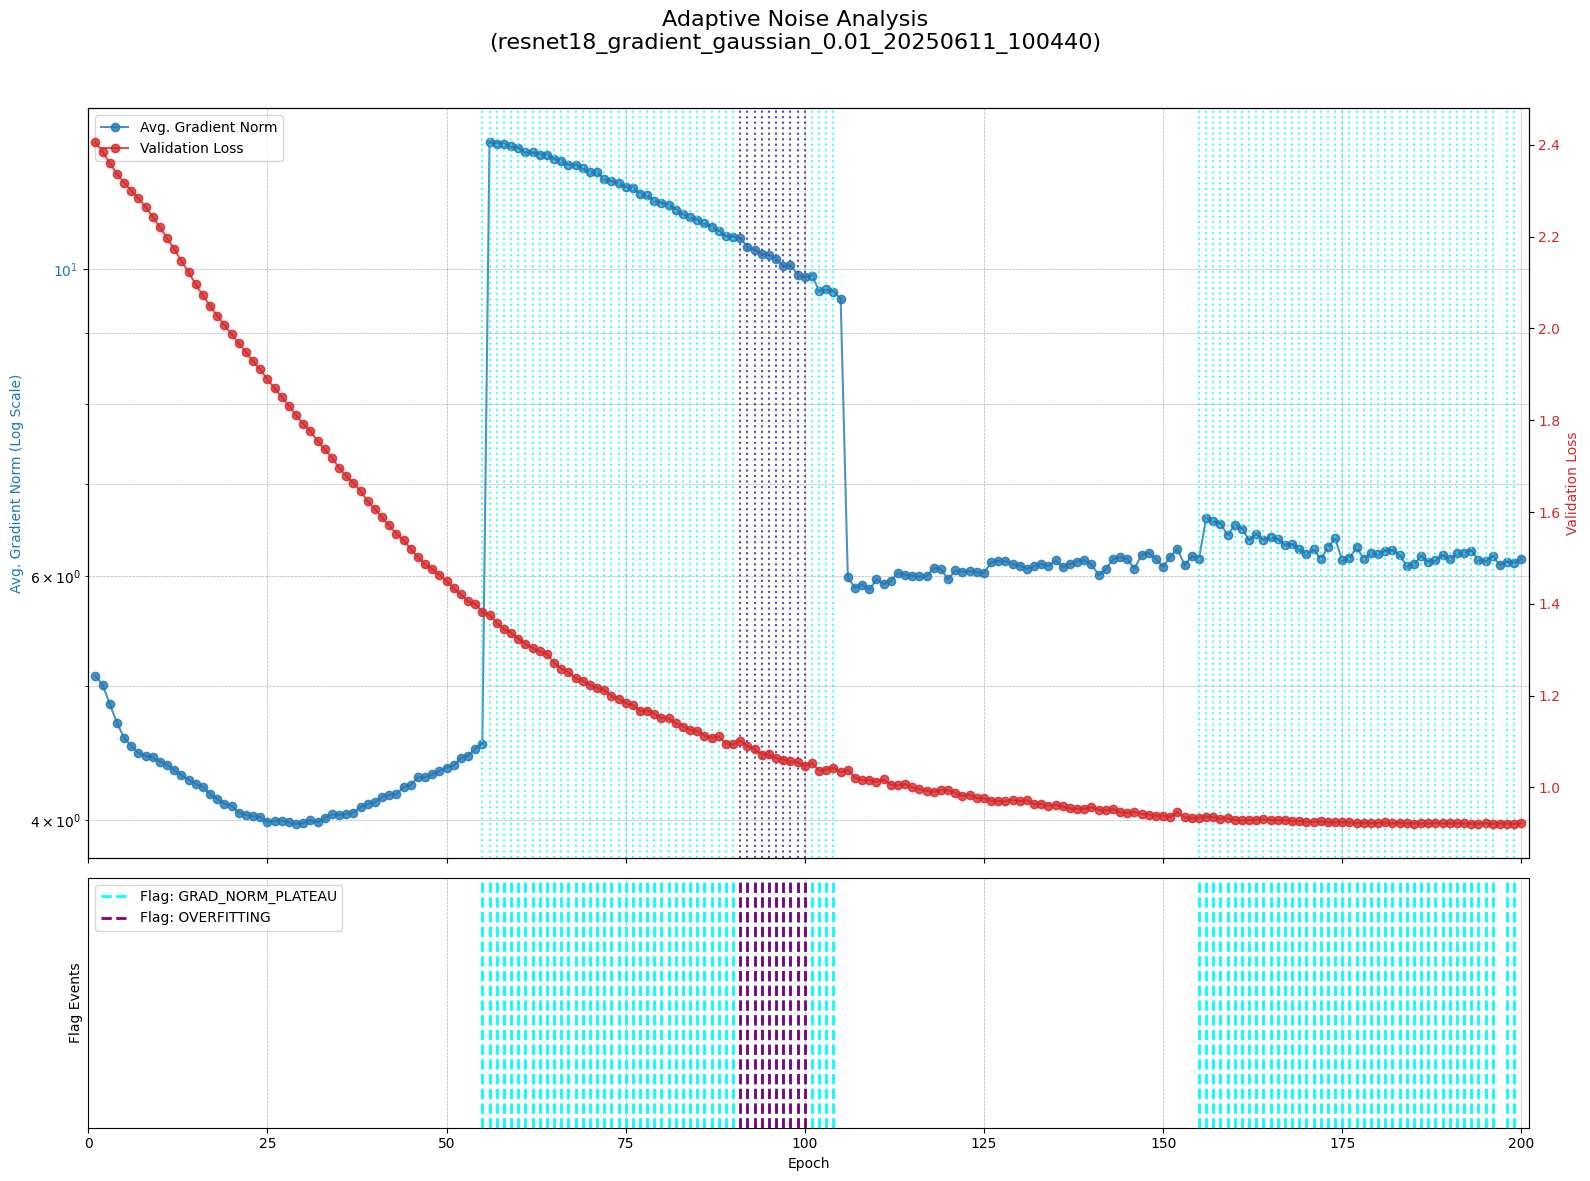

In [11]:
# --- USAGE EXAMPLE ---
# Use the same experiment path as before
experiment_path = r"C:\Users\Home\Documents\EPFL\OptML\OptML\PyTorch_CIFAR10\checkpoints\metrics\resnet18_gradient_gaussian_0.01_20250611_100440"

if os.path.isdir(experiment_path):
    plot_adaptive_noise_analysis(experiment_path)
else:
    print(f"Directory not found: '{experiment_path}'")
    print("Please update the 'experiment_path' variable with the correct path to your experiment's metrics folder.")

Successfully loaded 95 flag events from C:\Users\Home\Documents\EPFL\OptML\OptML\PyTorch_CIFAR10\checkpoints\metrics\baby_cnn_none_20250611_170125\optimization_flags.jsonl
Successfully loaded gradient norm data for 300 epochs from C:\Users\Home\Documents\EPFL\OptML\OptML\PyTorch_CIFAR10\checkpoints\metrics\baby_cnn_none_20250611_170125\all_metrics.json
Successfully loaded epoch data for 300 epochs.


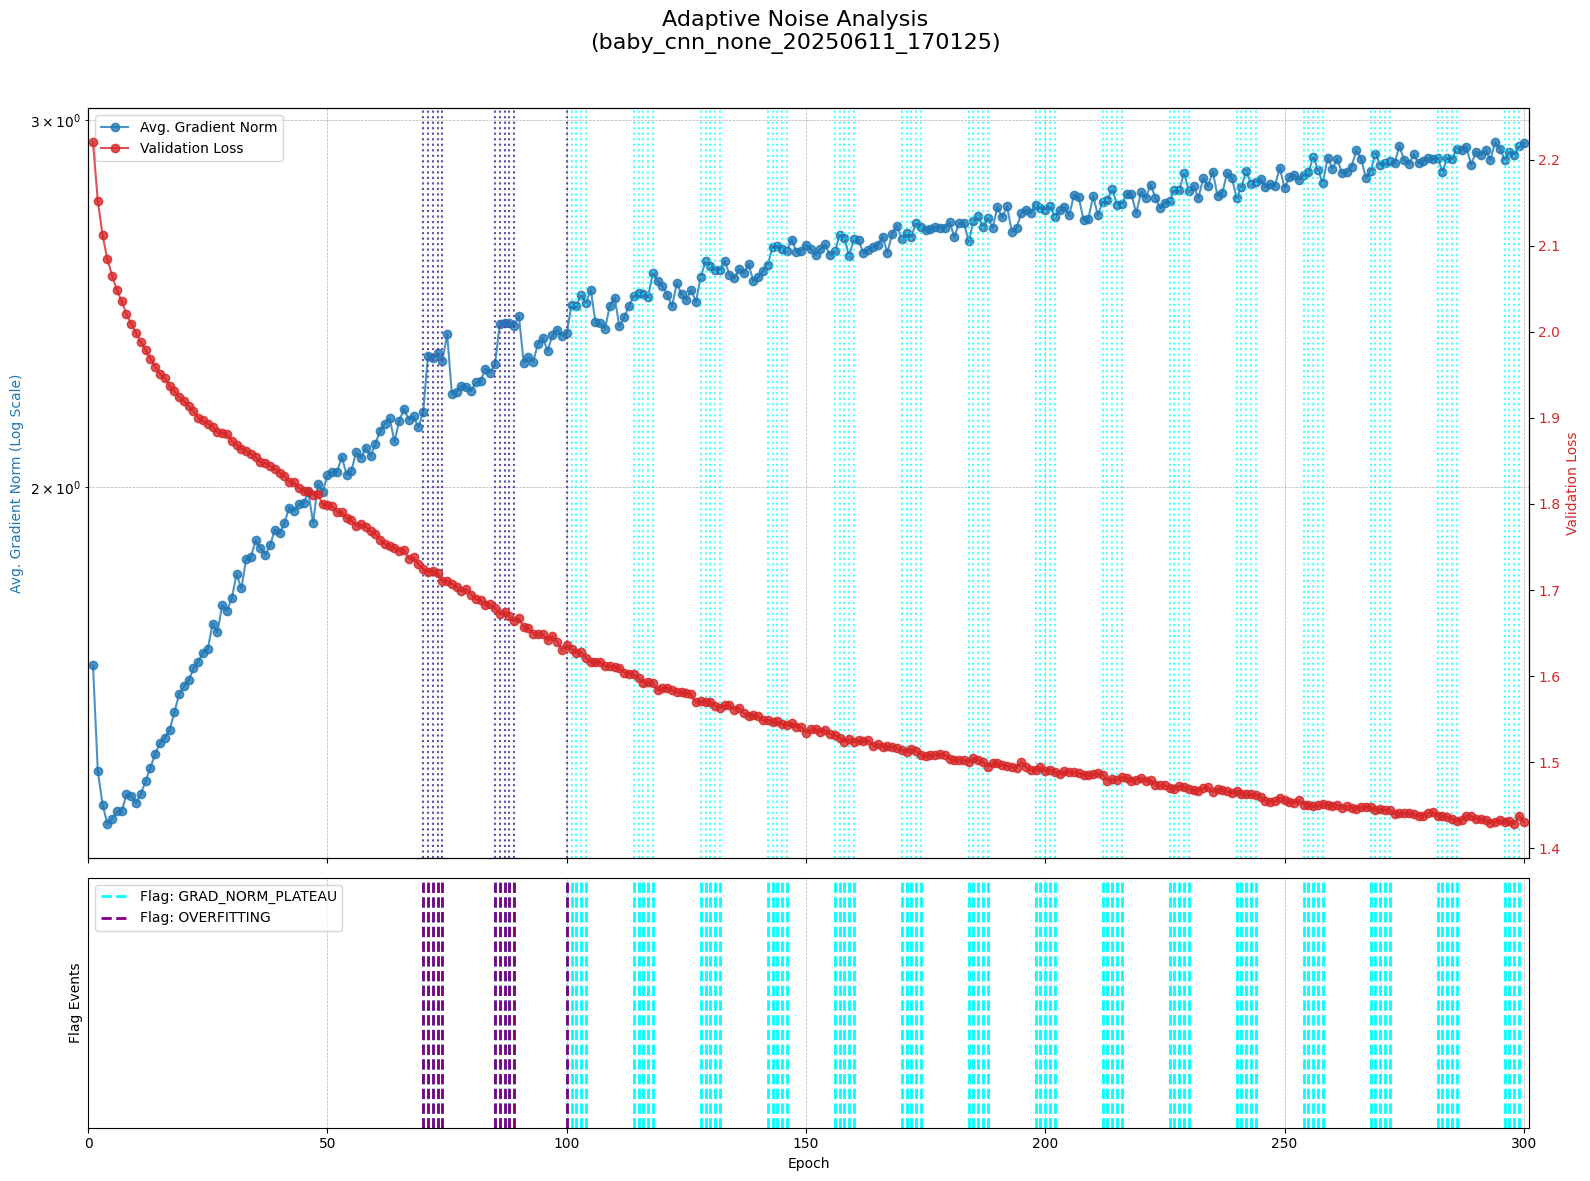

In [10]:
# --- USAGE EXAMPLE ---
# Use the same experiment path as before
experiment_path = r"C:\Users\Home\Documents\EPFL\OptML\OptML\PyTorch_CIFAR10\checkpoints\metrics\baby_cnn_none_20250611_170125"

if os.path.isdir(experiment_path):
    plot_adaptive_noise_analysis(experiment_path)
else:
    print(f"Directory not found: '{experiment_path}'")
    print("Please update the 'experiment_path' variable with the correct path to your experiment's metrics folder.")

C:\Users\Home\AppData\Local\Temp\ipykernel_34884\3067435245.py:26: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  flags_df = pd.read_json(flags_file, lines=True)


Successfully loaded gradient norm data for 300 epochs from C:\Users\Home\Documents\EPFL\OptML\OptML\PyTorch_CIFAR10\checkpoints\metrics\baby_cnn_none_20250611_151504\all_metrics.json
Successfully loaded epoch data for 300 epochs.


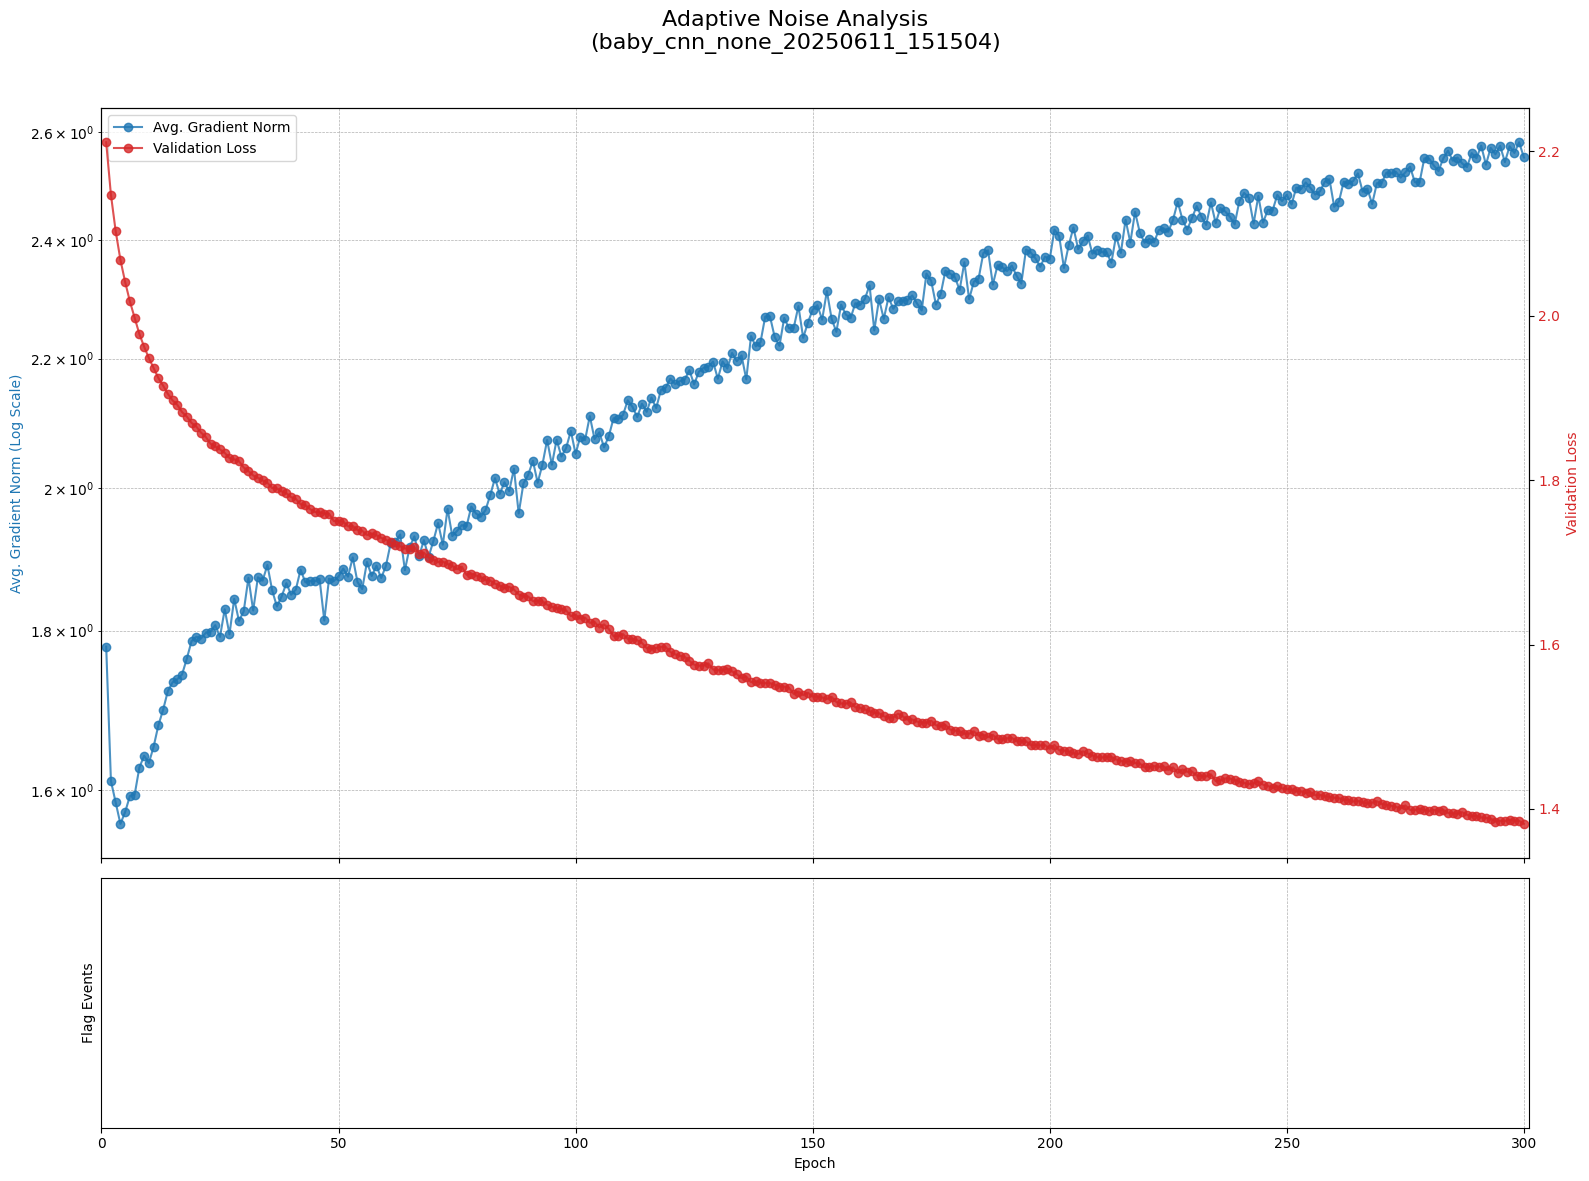

In [7]:
# --- USAGE EXAMPLE ---
# Use the same experiment path as before
experiment_path = r"C:\Users\Home\Documents\EPFL\OptML\OptML\PyTorch_CIFAR10\checkpoints\metrics\baby_cnn_none_20250611_151504"

if os.path.isdir(experiment_path):
    plot_adaptive_noise_analysis(experiment_path)
else:
    print(f"Directory not found: '{experiment_path}'")
    print("Please update the 'experiment_path' variable with the correct path to your experiment's metrics folder.")